In [2]:
library("Mfuzz")
library(ggpubr)
o<-function(w,h) options(repr.plot.width=w, repr.plot.height=h)

mFuzz.ggplot <- function(data, clustering, 
                         centre = TRUE, sort.columns = TRUE,
                         given.order=NA,nrow=2, ncol=4
                        ) {
    # from https://github.com/jspaezp/mFuzzOptim/blob/master/ggMfuzzplot.R    
    require(ggplot2)
    require(dplyr)
    require(tidyr)
    
    clusterindex <- clustering$cluster
    
    # data frame with Membership values
    memship <- clustering$membership 
    colnames(memship) <- paste("membership", 
        seq_along(memship[1,]), 
        sep = ("")) 
    
    exp <- exprs(data)
    
    # This chunk replaces col names by numbers if 
    # more than 1 is character only 
    # or when sort.columns is FALSE
    
    all.char.cols <- !grepl("\\d", colnames(exp))
    if ((sum(all.char.cols) > 1) | !sort.columns) {
        colnames(exp) <- seq_along(all.char.cols)    
    }
    
    exp <- data.frame(exp , 
            Identifier = rownames(data),
            clusterindex, memship) 
    
    # Transform data frame into a ggplot-compatible format
    exp <- exp %>% 
        gather(sample, 
            expression ,
            - Identifier,
            - clusterindex,
            - contains("membership")) %>% 
        mutate(Time = gsub("(\\w*\\D+(?=([0-9]+)))|((?<=\\d)\\D+$)", 
                "", 
                sample,
                perl = TRUE)) %>%
        #  this regular expression deletes all characters and numbers prior to 
        #  the last number in the string z.b. AA00AA00__00 -> 00 else keeps the string
        mutate(Time = gsub("^\\D*$", # this needs to be fixed, bug when seveal character cols ...
                "0", 
                Time,
                perl = TRUE)) %>%
        mutate(Time = as.numeric(Time))
    
    exp[["maxMembership"]] <- exp %>%  
        dplyr::select(contains("membership")) %>%
        apply(., 1, max) 
    
    
    #exp<- exp %>% filter(maxMembership>0.6) # filter here
    
    
    g <- ggplot(data = exp, aes(x = Time, y = expression)) +
        geom_line(aes(group = Identifier,  
                  colour = maxMembership, 
                  order = rank(maxMembership))) + 
        scale_colour_gradientn(colours = heat.colors(10, alpha=0.1))+ # change palette here
        #scale_colour_gradientn(colours = rainbow(5, alpha = 0.4)) 
        theme_pubr()
        
    
    # Center line plotting when centre == TRUE
    if (centre) {
        centers <- clustering$centers %>% 
                    data.frame(., clusterindex = rownames(.)) %>% 
                    gather(sample, Centre, - clusterindex) %>% 
                    mutate(Time = gsub("(\\w*\\D+(?=([0-9]+)))|((?<=\\d)\\D+$)", 
                            "", sample, perl = TRUE)) %>%
                    #  this regular expression deletes all characters and numbers prior to 
                    #  the last number in the string z.b. AA00AA00__00 -> 00 else keeps the string
                    mutate(Time = gsub("^\\D*$", # this needs to be fixed, bug when all character names
                            "0", Time, perl = TRUE)) %>%
                    mutate(Time = as.numeric(Time))
        
        g <- g + geom_line(data = centers, aes(x = Time, y = Centre))
    }
         
    
    g <- ggpubr::facet(g, facet.by = "clusterindex",
               nrow=nrow, ncol = ncol,scales='free',
               short.panel.labs = T,   # Allow long labels in panels
               panel.labs.background = list(fill = "lightgray", color = "lightgray"),
               strip.position='top'
    )
    
    #g <- g + facet_wrap(~clusterindex, ncol = 4,nrow=2)
    
    return(g)
} 

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: e1071

Warning message:
“no DISPLAY variable so Tk is not available”

Attaching package: ‘DynDoc’


The following object is ma

In [3]:
ilcp.hvg = read.csv('ilcp.hvg.csv')[,2]
alp1.hvg = read.csv('alp1.hvg.csv')[,2]

In [4]:
tf1=read.table("https://ghproxy.com/https://github.com/chansigit/SSAT/raw/master/mm.tf.csv",sep='\t')$x
tf2=read.table('https://www.grnpedia.org/trrust/data/trrust_rawdata.mouse.tsv',sep="\t")$V1
tf = unique(c(tf1,tf2))
length(tf)

[1] 1874

In [5]:
suppressPackageStartupMessages({
library(clusterProfiler)
library(org.Mm.eg.db)
library(enrichplot)
})

d <- GOSemSim::godata('org.Mm.eg.db', ont="BP")

preparing gene to GO mapping data...

preparing IC data...



# ABM analysis

## load data

In [6]:
# 1. load data
o(5,5)
goi = ilcp.hvg
mat = read.csv('./221112-ABM-ILCprimed-PathExpr.csv', row.names = 1)
colnames(mat) <- paste("T",0:(ncol(mat)-1), sep='')
mat = mat[ intersect(goi,rownames(mat)), ]

367 genes excluded.


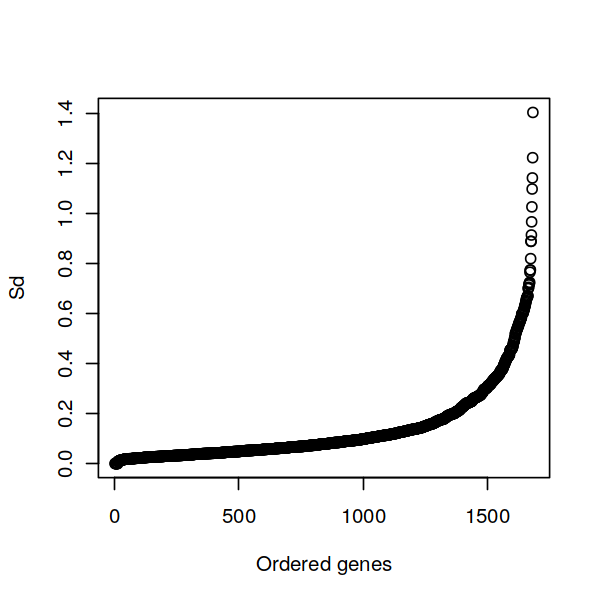

In [5]:
eset <- new("ExpressionSet",exprs = as.matrix(mat))
eset <- filter.std(eset,min.std=0.04) # filter data
eset <- standardise(eset)

## param est

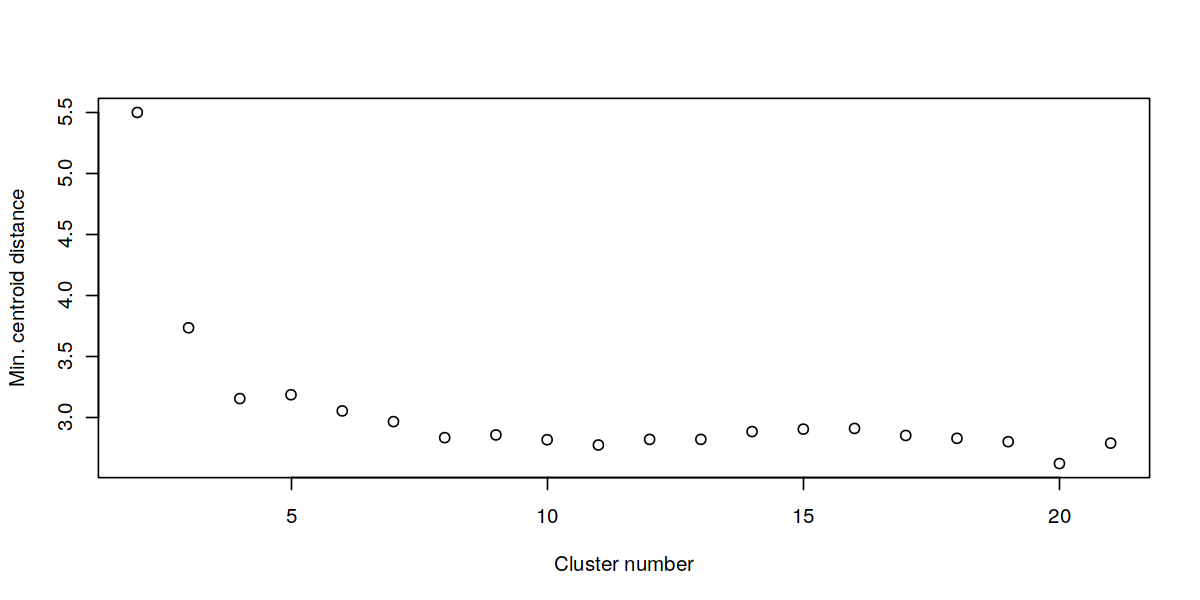

In [6]:
# 2. parameter estimation
m <- mestimate(eset)

# Find minimal distances among cluster centroids
o(10,5)
param.trial <-Dmin(eset, m=m, crange=seq(2,21,1), repeats=5, visu=T)

## do clustering

Warning message:
“Ignoring unknown aesthetics: order”


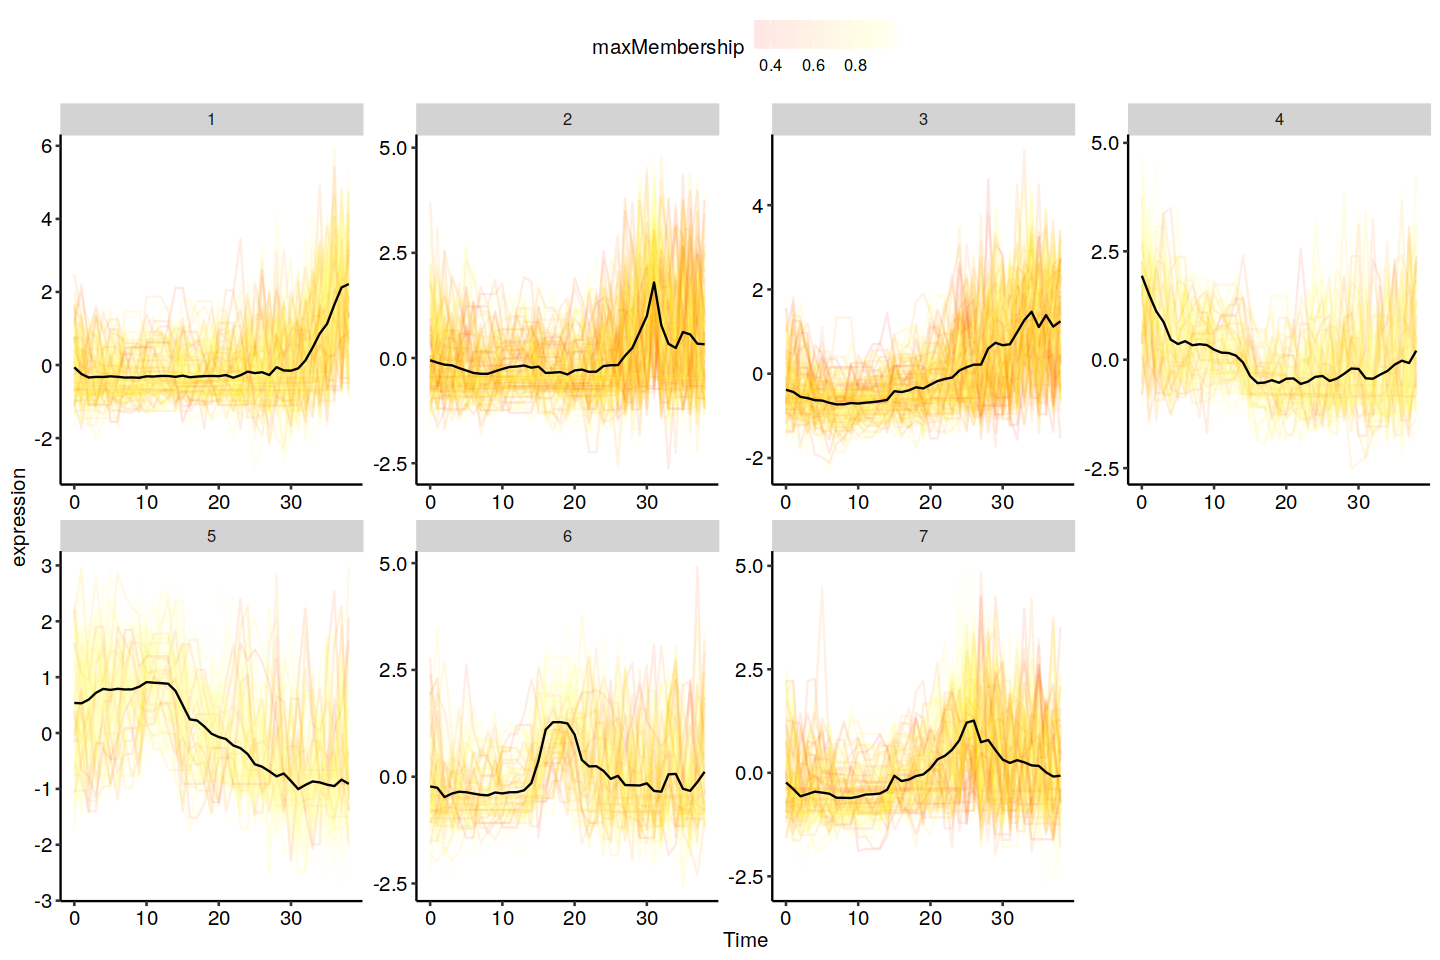

In [10]:
# 3. do clustering and show
c <- 7 # number of clusters
cl <- mfuzz(eset, c = c, m = m) # do clustering

o(4*4,4*2)
mfuzz.plot( eset,cl,mfrow=c(2,4), new.window= FALSE)


o(3*4, 4*2)
mFuzz.ggplot(eset, cl, centre = T, nrow=2,ncol=4)

In [11]:
# 4. extract cluster information
# find number of genes in each cluster
cl$size

# extract genes within a certain cluster
cluster_gene <- as.data.frame(cl$cluster)
colnames(cluster_gene)<-'GeneCluster'
cluster_gene <- cluster_gene %>% mutate(gene = rownames(.))

# Find gene-cluster memberships
membership   <- cl$membership
colnames(membership) <-paste('BelongToGC',colnames(membership), sep='')
membership <- membership %>% as.data.frame %>% mutate(gene= rownames(.))

[1] 262 187 269 143 155 126 175

In [12]:
# 5. explain clusters

get_cluster_genes<- function(membership, cluster, cutoff){
    df = membership[, cluster,drop=F]
    colnames(df) <- 'affinity'
    df <- df %>% filter(affinity>cutoff) %>% arrange(desc(affinity))
    rownames(df)
}

In [28]:
c1.gene    <- get_cluster_genes(membership, 1, cutoff = 0.6)
gene.df    <- bitr(c1.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
enrich.res <- enrichGO(gene= gene.df$ENSEMBL,readable=T,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
c1.enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
c1.enrich.tree <- treeplot(c1.enrich.res)

c2.gene    <- get_cluster_genes(membership, 2, cutoff = 0.6)
gene.df    <- bitr(c2.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
enrich.res <- enrichGO(gene= gene.df$ENSEMBL,readable=T,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
c2.enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
c2.enrich.tree <- treeplot(c2.enrich.res)

c3.gene    <- get_cluster_genes(membership, 3, cutoff = 0.6)
gene.df    <- bitr(c3.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
enrich.res <- enrichGO(gene= gene.df$ENSEMBL,readable=T,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
c3.enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
c3.enrich.tree <- treeplot(c3.enrich.res)

c4.gene    <- get_cluster_genes(membership, 4, cutoff = 0.6)
gene.df    <- bitr(c4.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
enrich.res <- enrichGO(gene= gene.df$ENSEMBL,readable=T,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
c4.enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
c4.enrich.tree <- treeplot(c4.enrich.res)

c5.gene    <- get_cluster_genes(membership, 5, cutoff = 0.6)
gene.df    <- bitr(c5.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
enrich.res <- enrichGO(gene= gene.df$ENSEMBL,readable=T,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
c5.enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
c5.enrich.tree <- treeplot(c5.enrich.res)

c6.gene    <- get_cluster_genes(membership, 6, cutoff = 0.6)
gene.df    <- bitr(c6.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
enrich.res <- enrichGO(gene= gene.df$ENSEMBL,readable=T,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
c6.enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
c6.enrich.tree <- treeplot(c6.enrich.res)

c7.gene    <- get_cluster_genes(membership, 7, cutoff = 0.6)
gene.df    <- bitr(c7.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
enrich.res <- enrichGO(gene= gene.df$ENSEMBL,readable=T,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
c7.enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
c7.enrich.tree <- treeplot(c7.enrich.res)



'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(c1.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“5.91% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(c2.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“7.28% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(c3.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“4.78% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(c4.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“0.74% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(c5.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“8.16% of input gene IDs are f

# Analysis results

Warning message:
“Ignoring unknown aesthetics: order”


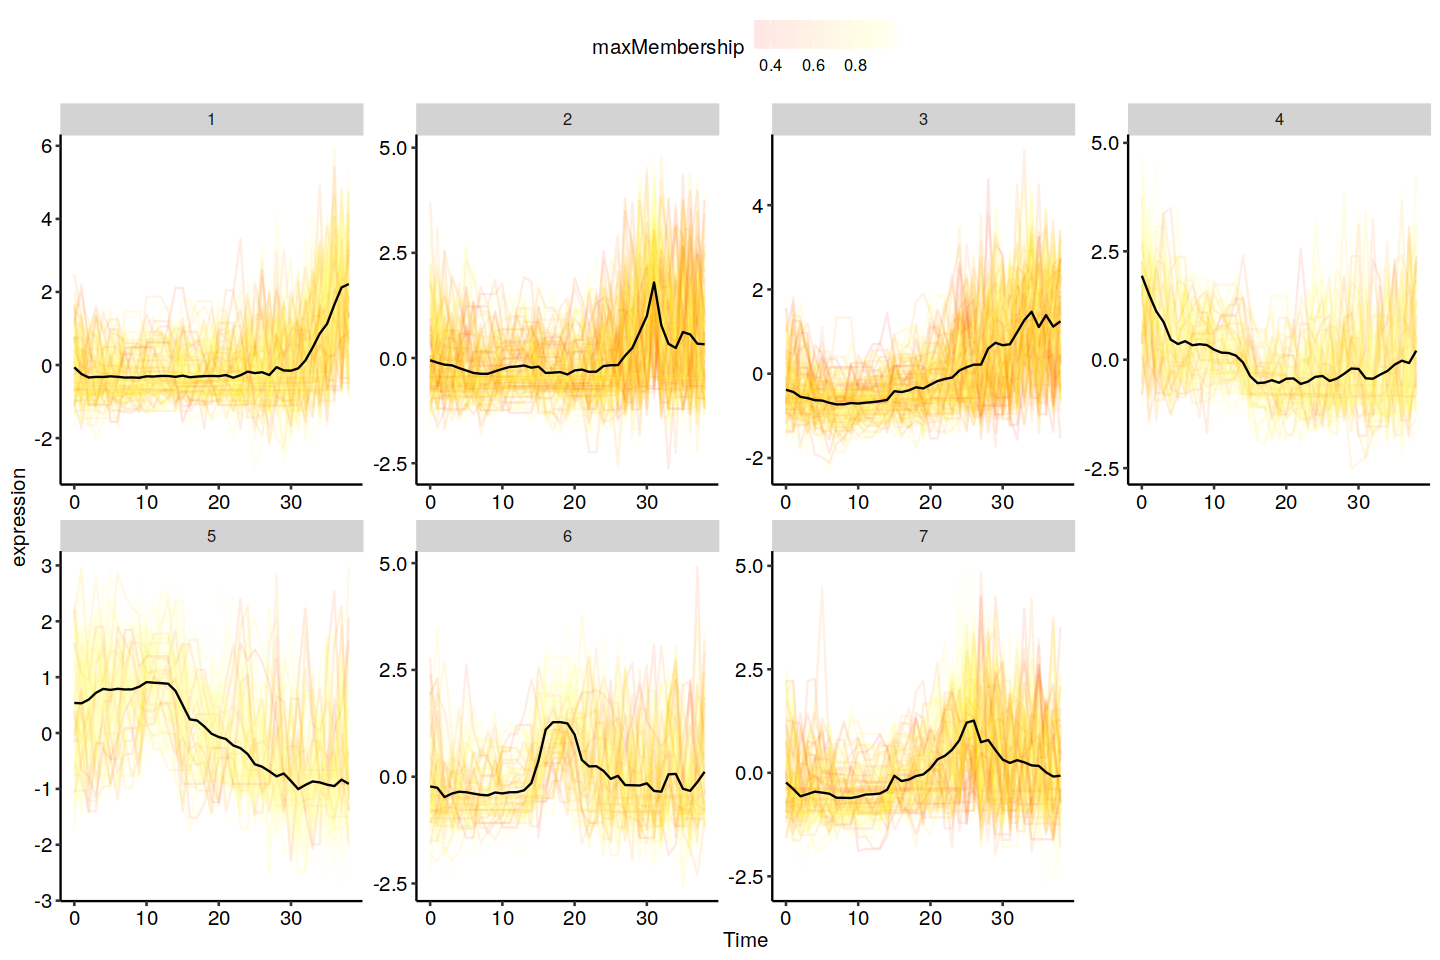

In [29]:
o(3*4, 4*2)
mFuzz.ggplot(eset, cl, centre = T, nrow=2,ncol=4)

In [65]:
terms.oi<-rbind(
    read.csv('./GOsel_differentiation.tsv', sep='\t', header = F),
    read.csv('./GOsel_activation.tsv', sep='\t', header = F),
    read.csv('./GOsel_others.tsv', sep='\t', header = F)
)
colnames(terms.oi)<-c('go','type','name')
terms.oi

go         type              
1  GO:0043367 biological_process
2  GO:0002292 biological_process
3  GO:1902105 biological_process
4  GO:0045582 biological_process
5  GO:0042093 biological_process
6  GO:0030217 biological_process
7  GO:0045619 biological_process
8  GO:0046632 biological_process
9  GO:1903706 biological_process
10 GO:0046651 biological_process
11 GO:0051251 biological_process
12 GO:0002366 biological_process
13 GO:0050870 biological_process
14 GO:0050863 biological_process
15 GO:0035710 biological_process
16 GO:0046631 biological_process
17 GO:0002501 biological_process
18 GO:1903037 biological_process
19 GO:0002495 biological_process
20 GO:0002460 biological_process
21 GO:0002474 biological_process
22 GO:0048535 biological_process
23 GO:0022408 biological_process
24 GO:0032620 biological_process
   name                                                                                                                     
1  CD4-positive, alpha-beta T cell differentiation                                                                          
2  T cell differentiation involved in immune response                                                                       
3  regulation of leukocyte differentiation                                                                                  
4  positive regulation of T cell differentiation                                                                            
5  T-helper cell differentiation                                                                                            
6  T cell differentiation                                                                                                   
7  regulation of lymphocyte differentiation                                                                                 
8  alpha-beta T cell differentiation                                                                                        
9  regulation of hemopoiesis                                                                                                
10 lymphocyte proliferation                                                                                                 
11 positive regulation of lymphocyte activation                                                                             
12 leukocyte activation involved in immune response                                                                         
13 positive regulation of T cell activation                                                                                 
14 regulation of T cell activation                                                                                          
15 CD4-positive, alpha-beta T cell activation                                                                               
16 alpha-beta T cell activation                                                                                             
17 peptide antigen assembly with MHC protein complex                                                                        
18 regulation of leukocyte cell-cell adhesion                                                                               
19 antigen processing and presentation of peptide antigen via MHC class II                                                  
20 adaptive immune response based on somatic recombination of immune receptors built from immunoglobulin superfamily domains
21 antigen processing and presentation of peptide antigen via MHC class I                                                   
22 lymph node development                                                                                                   
23 negative regulation of cell-cell adhesion                                                                                
24 interleukin-17 production

## G4 (Peak T =0)

[1] "Genes:"
Ctsb Cyth4 Siglech Rasa4 Ctss Jaml Blnk Sdc1 Ifi27l2a Ppfia4 Blk Pld4 Rnase6 Vim Cnn3 Ctsh Atp1b1 Marcks Cmah Scpep1 Tpm2 Ppp3cc Klrd1 Ly6d Acsf2 Foxn3 Ppp3ca Lgmn Ifi203 Gpr171 Tcf4 Itpr1 Rab33b Gm26759 Nrp1 Mpeg1 Gnb4 Tmem119 Slc35d3 Stap1 Sdc4 Sp100 Cox6a2 Ly6a Creld1 Egr1 Gm2a Fcgrt Tmem176b H2-DMb2 Nos1ap Hs3st1 Il18rap Ppp1r16b Tsc22d3 Ctnnd2 Ccnd3 Snrk Psap Tmem176a Tpm4 Ppp1r18 Tdrd7 Emb Epsti1 Serpinb1a Sell Lat2 Ccrl2 Gclc Capg Evl Arid5a Il21r Irf8 Myo1c Cd53 Slpi Tmem108 Ccdc102a Lgals1 Samsn1 Cers4 Il12a Dap Zfp36 Coro2a Rell1 Stat1 Irf2bpl Tdrkh Ptms Smim14 Prickle3 Cd69 H2-Ob Tmem50b Cldnd1 Fgl2 Ctr9 Arpp21 Oscp1 Klf3 Prr5 Tbc1d4 Cd52 Foxo1 Atp2b1 Gpatch2 Napsa Glipr1 I830077J02Rik Jakmip1 Cd3d Ly6c2 3830403N18Rik Ighm Maml3 H2-DMb1 Klrb1f Satb1 Rassf2 4930523C07Rik Sorl1 Ms4a4b Eno1 Hcst Gpr132 Tmem141 Endov Tubb2a Myo1f Peak1 Abhd14b Mgst2NULL
[1] "TFs:"
Foxn3 Tcf4 Sp100 Egr1 Tsc22d3 Arid5a Irf8 Zfp36 Stat1 Ctr9 Klf3 Foxo1 Satb1NULL


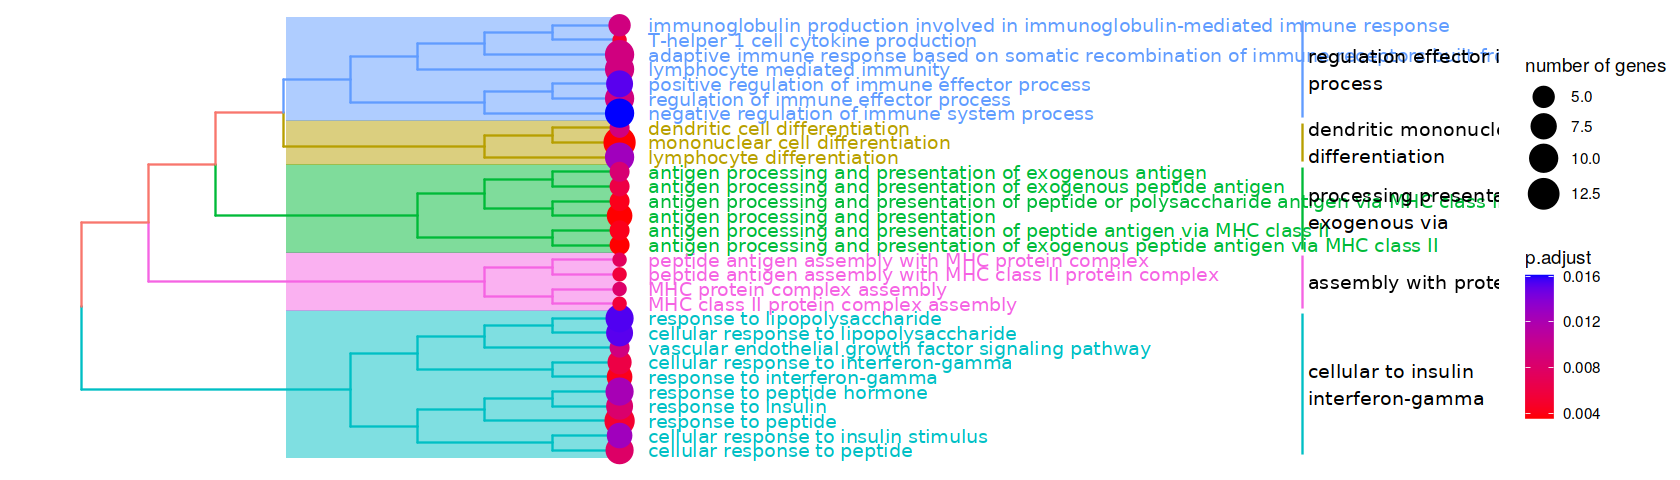

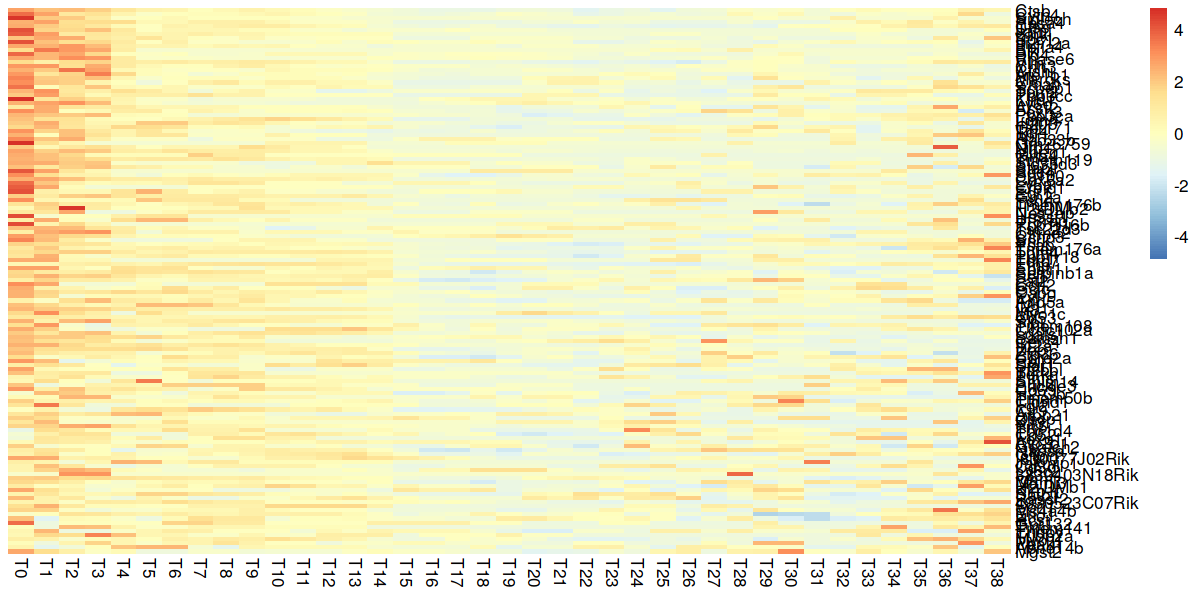

In [36]:
print('Genes:')
print(cat(c4.gene))

print('TFs:')
print(cat(intersect(c4.gene, tf)))

o(14,4)
plot(c4.enrich.tree)

library(pheatmap)
o(10,5)
pheatmap(mat[c4.gene,], scale = 'row', 
         cluster_rows = F, cluster_cols = F, border_color=NA)


In [37]:
as.data.frame(c4.enrich.res)


ID        
GO:1903131 GO:1903131
GO:0019886 GO:0019886
GO:0019882 GO:0019882
GO:0002495 GO:0002495
GO:0034341 GO:0034341
GO:0002504 GO:0002504
GO:1901652 GO:1901652
GO:0035744 GO:0035744
GO:0002399 GO:0002399
GO:0002503 GO:0002503
GO:0002478 GO:0002478
GO:0071346 GO:0071346
GO:0002501 GO:0002501
GO:1901653 GO:1901653
GO:0002396 GO:0002396
GO:0032868 GO:0032868
GO:0019884 GO:0019884
GO:0002449 GO:0002449
GO:0038084 GO:0038084
GO:0002460 GO:0002460
GO:0002381 GO:0002381
GO:0002697 GO:0002697
GO:0097028 GO:0097028
GO:0043434 GO:0043434
GO:0032869 GO:0032869
GO:0030098 GO:0030098
GO:0071222 GO:0071222
GO:0002699 GO:0002699
GO:0032496 GO:0032496
GO:0002683 GO:0002683
⋮          ⋮         
GO:0002237 GO:0002237
GO:0035924 GO:0035924
GO:1903706 GO:1903706
GO:0002366 GO:0002366
GO:0071216 GO:0071216
GO:0002263 GO:0002263
GO:0050853 GO:0050853
GO:0046651 GO:0046651
GO:0032943 GO:0032943
GO:0002831 GO:0002831
GO:0032103 GO:0032103
GO:1900078 GO:1900078
GO:0071375 GO:0071375
GO:0019722 GO:0019722
GO:0048002 GO:0048002
GO:0045954 GO:0045954
GO:0070661 GO:0070661
GO:0046466 GO:0046466
GO:0099173 GO:0099173
GO:0002717 GO:0002717
GO:0007015 GO:0007015
GO:1900076 GO:1900076
GO:0007159 GO:0007159
GO:0031345 GO:0031345
GO:0002456 GO:0002456
GO:0002440 GO:0002440
GO:0045088 GO:0045088
GO:0001912 GO:0001912
GO:0010612 GO:0010612
GO:0042098 GO:0042098
           Description                                                                                                              
GO:1903131 mononuclear cell differentiation                                                                                         
GO:0019886 antigen processing and presentation of exogenous peptide antigen via MHC class II                                        
GO:0019882 antigen processing and presentation                                                                                      
GO:0002495 antigen processing and presentation of peptide antigen via MHC class II                                                  
GO:0034341 response to interferon-gamma                                                                                             
GO:0002504 antigen processing and presentation of peptide or polysaccharide antigen via MHC class II                                
GO:1901652 response to peptide                                                                                                      
GO:0035744 T-helper 1 cell cytokine production                                                                                      
GO:0002399 MHC class II protein complex assembly                                                                                    
GO:0002503 peptide antigen assembly with MHC class II protein complex                                                               
GO:0002478 antigen processing and presentation of exogenous peptide antigen                                                         
GO:0071346 cellular response to interferon-gamma                                                                                    
GO:0002501 peptide antigen assembly with MHC protein complex                                                                        
GO:1901653 cellular response to peptide                                                                                             
GO:0002396 MHC protein complex assembly                                                                                             
GO:0032868 response to insulin                                                                                                      
GO:0019884 antigen processing and presentation of exogenous antigen                                                                 
GO:0002449 lymphocyte mediated immunity                                                                                             
GO:0038084 vascular endothelial growth factor signaling pathway                                                         

## G5 (Peak T=10)

[1] "Genes:"
Lmnb1 Spi1 Tuba1b Ranbp1 Dut Cks1b Cdk1 Lig1 Dctpp1 Ran Gmnn Pcna Mcm6 Mcm5 Mcm3 Ncl Tubb5 Dek Phgdh Tk1 Hmgb2 Cd34 Tipin Cdca3 Spc24 Ifitm2 Npm1 Rasgrp2 Cdca8 Cycs Srm Tyms H2afz Stmn1 H2afx Rrm2 Birc5 Top2a Hells Ccnd2 Pbk Mki67 Ncapd2 Mif Pclaf Mpo Hist1h2ae Plk4 H2afy Prtn3 Hmgn2 Plac8 Gpx1 Bex6 Ramp1 Tubb4b Ifitm1 Lmo2 Pou2f2 Hist1h1b Fth1 Cdc20 Lgals9 Zfp706 BC035044 Lpcat1 Anxa3 Hist1h2ac Ung Dntt Nusap1 Cenpe Hspa5 Egfl7 Ctsg Tep1 Cenpf Rel Gadd45b Ifitm3 Unc93b1 H1fx Alox5ap Calr Dusp2 B930036N10Rik Il1r1 Ccl9 Lockd Asf1b H2afv Ifngr2 Rgs10 Bpifc Ccnd1 Fabp5 Fxyd5 Hist1h1e Ly86 Lfng Flt3 Hp Ms4a6c Gadd45g Slc20a1 Bst2 Samhd1 Myl10 Wwc2 Dgat1 Fosb Il4ra Myc Riox2 Pycr2 Zfp799 Ier3 Ccnb2 Dock10 Nav1 Cst3 Cd244 Trmt44 Slc2a6 Lpcat2 Ebi3 Klf10 Mef2c Tgtp2 Ly6e Ms4a2 Scaf11 Cd79b Lyl1 Atp8b4 Naga Ccl3 Nr4a1 Exoc1 Wfdc17 Clec12a Fam46a Cfp Tsc22d1 Nfil3 Pglyrp1 Tnfrsf1bNULL
[1] "TFs:"
Spi1 Mcm6 Mcm3 Hmgb2 Lmo2 Pou2f2 Zfp706 Rel Ccnd1 Fosb Myc Zfp799 Klf10 Mef2c Lyl1 Nr4

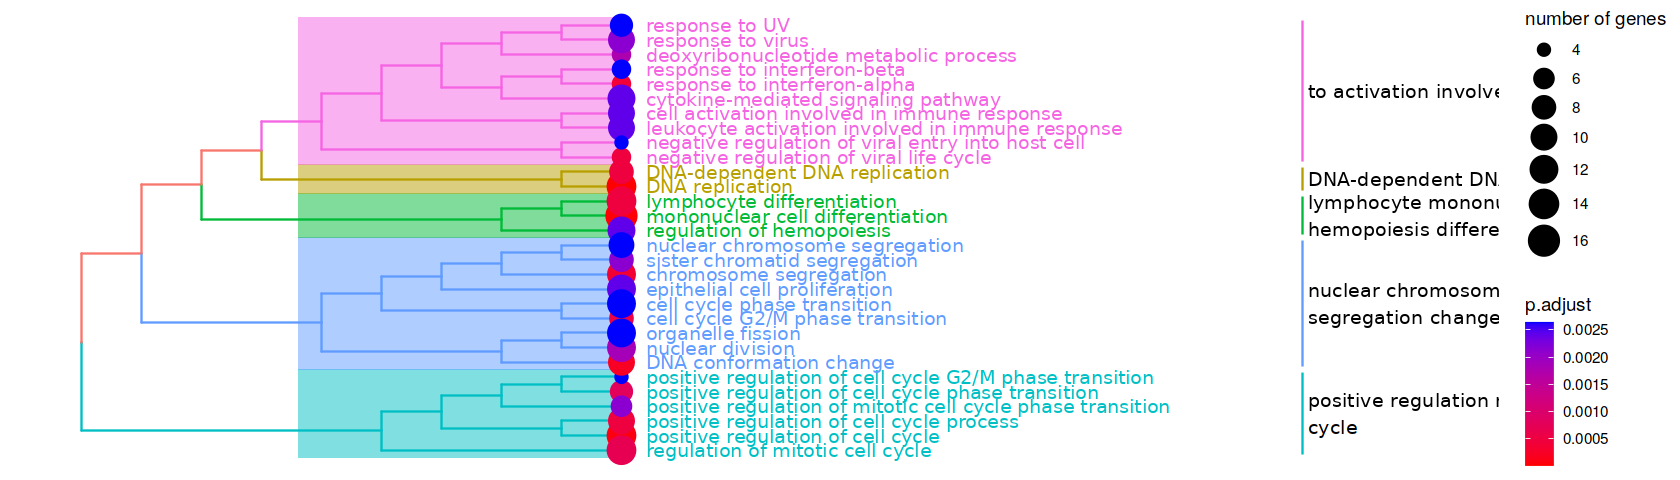

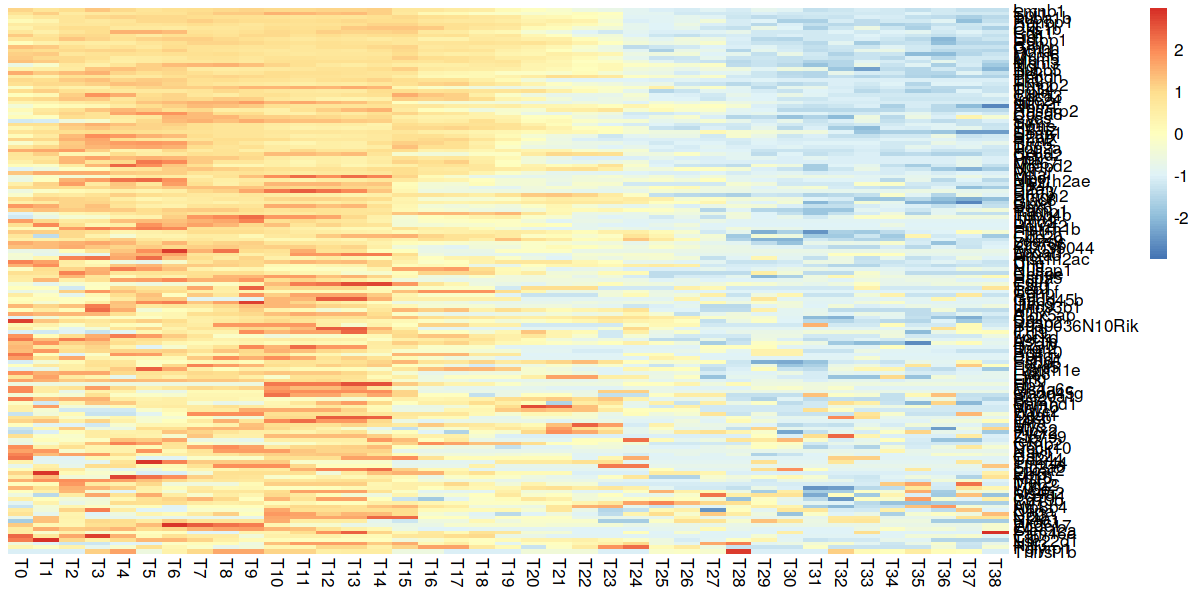

In [38]:

print('Genes:')
print(cat(c5.gene))

print('TFs:')
print(cat(intersect(c5.gene, tf)))

o(14,4)
plot(c5.enrich.tree)

library(pheatmap)
o(10,5)
pheatmap(mat[c5.gene,], scale = 'row', 
         cluster_rows = F, cluster_cols = F, border_color=NA)

In [39]:
as.data.frame(c5.enrich.res)

ID        
GO:0006260 GO:0006260
GO:1903131 GO:1903131
GO:0045787 GO:0045787
GO:0071103 GO:0071103
GO:0007059 GO:0007059
GO:0035455 GO:0035455
GO:1903901 GO:1903901
GO:0030098 GO:0030098
GO:0006261 GO:0006261
GO:0090068 GO:0090068
GO:0044839 GO:0044839
GO:0007346 GO:0007346
GO:1901989 GO:1901989
GO:0009262 GO:0009262
GO:0000280 GO:0000280
GO:0000819 GO:0000819
GO:1901992 GO:1901992
GO:0009615 GO:0009615
GO:0002366 GO:0002366
GO:0002263 GO:0002263
GO:0050673 GO:0050673
GO:0019221 GO:0019221
GO:1903706 GO:1903706
GO:0046597 GO:0046597
GO:1902751 GO:1902751
GO:0009411 GO:0009411
GO:0098813 GO:0098813
GO:0044770 GO:0044770
GO:0035456 GO:0035456
GO:0048285 GO:0048285
⋮          ⋮         
GO:0002274 GO:0002274
GO:0000077 GO:0000077
GO:1902106 GO:1902106
GO:0040013 GO:0040013
GO:0002700 GO:0002700
GO:0019058 GO:0019058
GO:1903557 GO:1903557
GO:0071674 GO:0071674
GO:0002367 GO:0002367
GO:1903707 GO:1903707
GO:0001935 GO:0001935
GO:0009176 GO:0009176
GO:0071428 GO:0071428
GO:0072672 GO:0072672
GO:0035019 GO:0035019
GO:0042743 GO:0042743
GO:0051445 GO:0051445
GO:0002275 GO:0002275
GO:0008630 GO:0008630
GO:0051225 GO:0051225
GO:0043470 GO:0043470
GO:0009147 GO:0009147
GO:0019985 GO:0019985
GO:0032823 GO:0032823
GO:1902570 GO:1902570
GO:0001659 GO:0001659
GO:0031570 GO:0031570
GO:0043388 GO:0043388
GO:0031349 GO:0031349
GO:0070661 GO:0070661
           Description                                                                 
GO:0006260 DNA replication                                                             
GO:1903131 mononuclear cell differentiation                                            
GO:0045787 positive regulation of cell cycle                                           
GO:0071103 DNA conformation change                                                     
GO:0007059 chromosome segregation                                                      
GO:0035455 response to interferon-alpha                                                
GO:1903901 negative regulation of viral life cycle                                     
GO:0030098 lymphocyte differentiation                                                  
GO:0006261 DNA-dependent DNA replication                                               
GO:0090068 positive regulation of cell cycle process                                   
GO:0044839 cell cycle G2/M phase transition                                            
GO:0007346 regulation of mitotic cell cycle                                            
GO:1901989 positive regulation of cell cycle phase transition                          
GO:0009262 deoxyribonucleotide metabolic process                                       
GO:0000280 nuclear division                                                            
GO:0000819 sister chromatid segregation                                                
GO:1901992 positive regulation of mitotic cell cycle phase transition                  
GO:0009615 response to virus                                                           
GO:0002366 leukocyte activation involved in immune response                            
GO:0002263 cell activation involved in immune response                                 
GO:0050673 epithelial cell proliferation                                               
GO:0019221 cytokine-mediated signaling pathway                                         
GO:1903706 regulation of hemopoiesis                                                   
GO:0046597 negative regulation of viral entry into host cell                           
GO:1902751 positive regulation of cell cycle G2/M phase transition                     
GO:0009411 response to UV                                                              
GO:0098813 nuclear chromosome segregation                                              
GO:0044770 cell cycle phase transition                                                 
GO:0035456 response to interferon-beta                                                 
GO:0048

## G6 (Peak T =18)

[1] "Genes:"
Hba-a1 Tubb3 Rhd Adra1b Tnfaip2 Car1 Klf1 Aqp1 Hba-a2 Hebp1 Car2 Hbb-bt Cd4 Hbb-bs Usp32 Actn1 C1qtnf12 Emilin2 Mboat2 Mt1 Isg20 Rnf125 Blvrb Gstm5 Jade2 Lmna Klhl8 4930519L02Rik Anxa2 Arhgap35 B3galnt1 Cenpa Agpat4 Ctse 1600014C10Rik Ankfy1 Adgre5 F2r Pnck Il17rb Spc25 Cd81 Ube2c Tmem168 Dkkl1 Alox5 Adgrg1 Csrp3 Cdkn1c Spata7 1700006J14Rik Cpne2 Dph6 Hmgb3 Maml2 Trf H1f0 Slc25a20 Basp1 Siglecf Aplp2 Marf1 Rgcc Neat1 Crebbp Nck2 Ppp1r15a Trdc Bcl11b Perp March6 Smim5 1700097N02Rik Abi3 Tcrg-C2 Akr1c13 Wls Mgst3 Fut8 Ano6 Bbs4 Tmem158 Gm26917 Atg2a Rnf213 Adgrl2 Nr4a2 Comt Nfatc3 Phc1 Baiap2 Jchain Arhgap6 Gmcl1 Aldoa Aqp11 Terf2ip Gcfc2 4930402H24Rik Siglecg Tcf12 Ddhd2 Zfp667 Jund Eno3 Phf21a Krt18 Rapsn Mfsd10NULL
[1] "TFs:"
Klf1 Cenpa Hmgb3 Crebbp Bcl11b Nr4a2 Nfatc3 Gcfc2 Tcf12 Zfp667 JundNULL


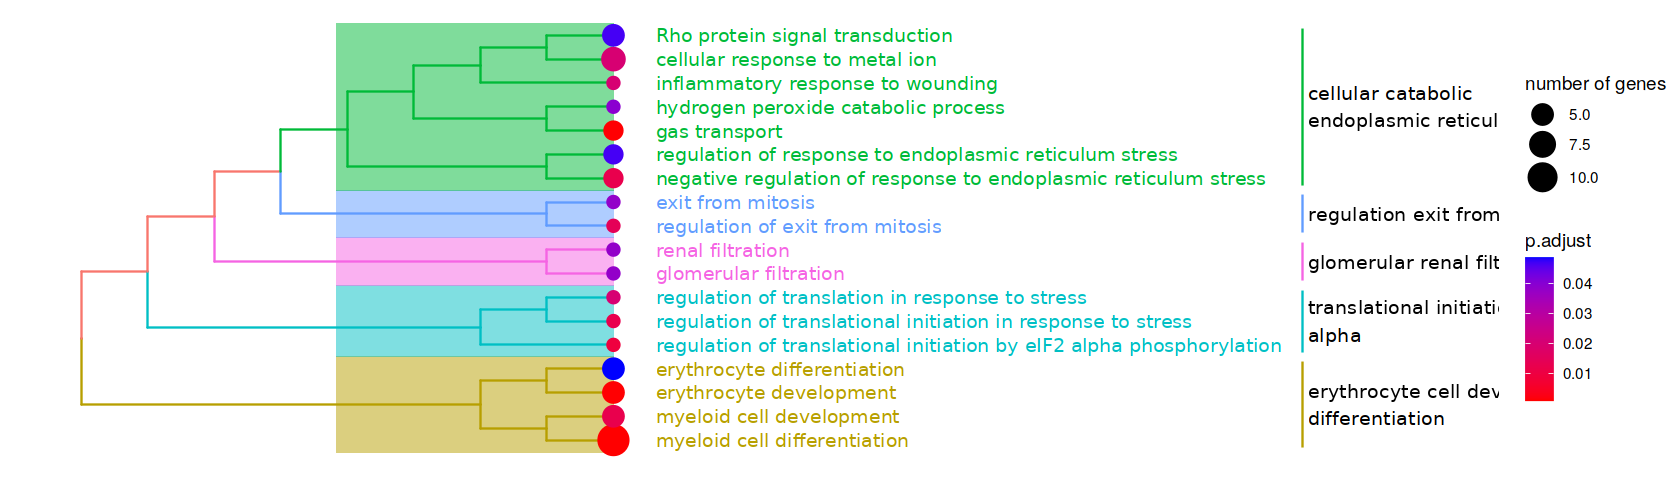

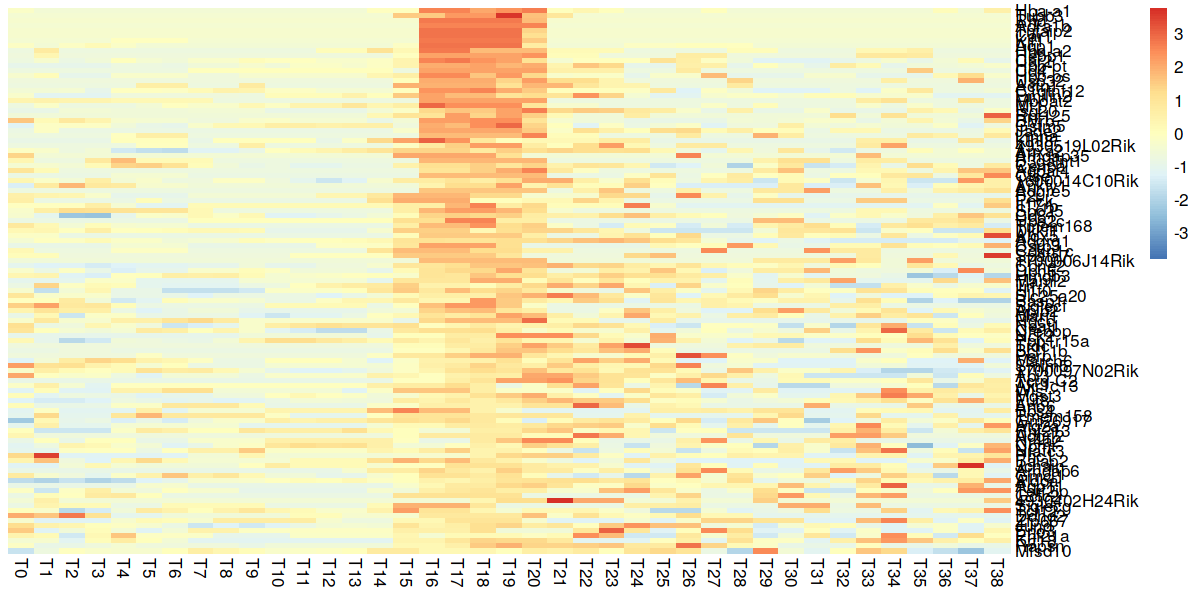

In [40]:
print('Genes:')
print(cat(c6.gene))

print('TFs:')
print(cat(intersect(c6.gene, tf)))

o(14,4)
plot(c6.enrich.tree)

library(pheatmap)
o(10,5)
pheatmap(mat[c6.gene,], scale = 'row', 
         cluster_rows = F, cluster_cols = F, border_color=NA)

In [41]:
as.data.frame(c6.enrich.res)

ID        
GO:0030099 GO:0030099
GO:0015669 GO:0015669
GO:0048821 GO:0048821
GO:0010998 GO:0010998
GO:1903573 GO:1903573
GO:0043558 GO:0043558
GO:0061515 GO:0061515
GO:0007096 GO:0007096
GO:0071248 GO:0071248
GO:0043555 GO:0043555
GO:0090594 GO:0090594
GO:0003094 GO:0003094
GO:0010458 GO:0010458
GO:0097205 GO:0097205
GO:0042744 GO:0042744
GO:1905897 GO:1905897
GO:0007266 GO:0007266
GO:0030218 GO:0030218
           Description                                                         
GO:0030099 myeloid cell differentiation                                        
GO:0015669 gas transport                                                       
GO:0048821 erythrocyte development                                             
GO:0010998 regulation of translational initiation by eIF2 alpha phosphorylation
GO:1903573 negative regulation of response to endoplasmic reticulum stress     
GO:0043558 regulation of translational initiation in response to stress        
GO:0061515 myeloid cell development                                            
GO:0007096 regulation of exit from mitosis                                     
GO:0071248 cellular response to metal ion                                      
GO:0043555 regulation of translation in response to stress                     
GO:0090594 inflammatory response to wounding                                   
GO:0003094 glomerular filtration                                               
GO:0010458 exit from mitosis                                                   
GO:0097205 renal filtration                                                    
GO:0042744 hydrogen peroxide catabolic process                                 
GO:1905897 regulation of response to endoplasmic reticulum stress              
GO:0007266 Rho protein signal transduction                                     
GO:0030218 erythrocyte differentiation                                         
           GeneRatio BgRatio   pvalue       p.adjust    qvalue      
GO:0030099 12/102    425/22853 4.378311e-07 0.000894489 0.0007788785
GO:0015669 4/102     18/22853  1.090777e-06 0.001033433 0.0008998643
GO:0048821 5/102     44/22853  1.517523e-06 0.001033433 0.0008998643
GO:0010998 3/102     12/22853  1.844418e-05 0.009420363 0.0082028043
GO:1903573 4/102     41/22853  3.336230e-05 0.012245891 0.0106631402
GO:0043558 3/102     15/22853  3.777593e-05 0.012245891 0.0106631402
GO:0061515 5/102     86/22853  4.195851e-05 0.012245891 0.0106631402
GO:0007096 3/102     17/22853  5.609087e-05 0.014324206 0.0124728379
GO:0071248 6/102     167/22853 1.050117e-04 0.020112805 0.0175132751
GO:0043555 3/102     21/22853  1.082921e-04 0.020112805 0.0175132751
GO:0090594 3/102     21/22853  1.082921e-04 0.020112805 0.0175132751
GO:0003094 3/102     27/22853  2.335727e-04 0.038051631 0.0331335531
GO:0010458 3/102     28/22853  2.607552e-04 0.038051631 0.0331335531
GO:0097205 3/102     28/22853  2.607552e-04 0.038051631 0.0331335531
GO:0042744 3/102     29/22853  2.899016e-04 0.039484598 0.0343813128
GO:1905897 4/102     76/22853  3.750254e-04 0.046738813 0.0406979386
GO:0007266 5/102     138/22853 3.889182e-04 0.046738813 0.0406979386
GO:0030218 5/102     141/22853 4.292087e-04 0.048715190 0.0424188740
           geneID                                                            
GO:0030099 Hba-a1/Rhd/Klf1/Hba-a2/Car2/Cd4/Hbb-b1/Actn1/Cd81/Cdkn1c/Hmgb3/Trf
GO:0015669 Aqp1/Car2/Hbb-bt/Hbb-b1                                           
GO:0048821 Hba-a1/Rhd/Klf1/Hba-a2/Hbb-b1                                     
GO:0010998 Hbb-b1/Nck2/Ppp1r15a                                              
GO:1903573 Alox5/Nck2/Ppp1r15a/Aqp11                                         
GO:0043558 Hbb-b1/Nck2/Ppp1r15a                                              
GO:0061515 Hba-a1/Rhd/Klf1/Hba-a2/Hbb-b1                                     
GO:0007096 Ube2c/Cdkn1c/Rgcc                                                 
GO:0071248 Aqp1/Mt1/Cpne2/Trf/Nfatc3/Jund                   

## G7 (Peak T =26)

[1] "genes"
Mycn Grb2 Cpa3 Gyg Dhrs2 Cebpb Skp1a Itga4 Sox4 Sik1 Itga2b Ccnjl Zfp831 Mta3 Tcf7 Fgf3 AC153891.1 Gse1 5830418P13Rik Lat Gramd1a Ambra1 Mif4gd Colq Mark4 Slc22a3 Hvcn1 Rab44 Heg1 Runx3 Mn1 Fbxw4 Fhl2 4930481A15Rik Nbr1 Ctla2a Actb Inafm1 Isg15 Pygl Tfr2 Dbn1 Pdgfrb Dhx34 Stoml1 Ppm1k Marcksl1 Pim1 Ddc Ifi27 Map4k4 Cd72 Narf Adcy9 Zrsr1 Nfkbie Lck Abcb9 Gstp3 Dok3 Amn1 Kdm6b P2ry14 Tmem123 Atg9a Dhx58 Zc3hav1 Cpb1 Bcl9l Marveld2 Rab8b C1qtnf4 Tha1 Ptprk Rec8 Ier2 Bbc3 Pear1 1110035H17Rik Xaf1 Gfi1b Ralgds Cyp4f13 Prkca Kdm4a Cd24a Prkacb Crip1 Tmem121 2900026A02Rik Baiap3 Calm2 Cd63 Cdkn1a Cttn Vps37b Plekho1 Kdm5c Crybg1 Peli1 Ndrg2 Nedd9 E230032D23Rik Dlgap4 Klf7 Zmynd8 Rgs1 Irf7 Kit Chn2 Ap3s1 Tuba8 Trac Adora2a Zfp26 Slc25a36 Nfkb1 Gm9888 Slc39a1 Rnf122 Itk Fbxo6 Ncor2 H2-T23 Plekhg5 Stat4 Wipf1 AC161165.6 Dgka Dcaf5 Tspan32 Parp9 Rhob Tatdn1 Cyp4f16 Zbp1 Cd7 Rrm2b Paip2b Camk2b Pi16 Man2a1 DroshaNULL
[1] "TFs"
Mycn Cebpb Sox4 Zfp831 Mta3 Tcf7 Runx3 Fhl2 Kdm6b Gfi1b Klf

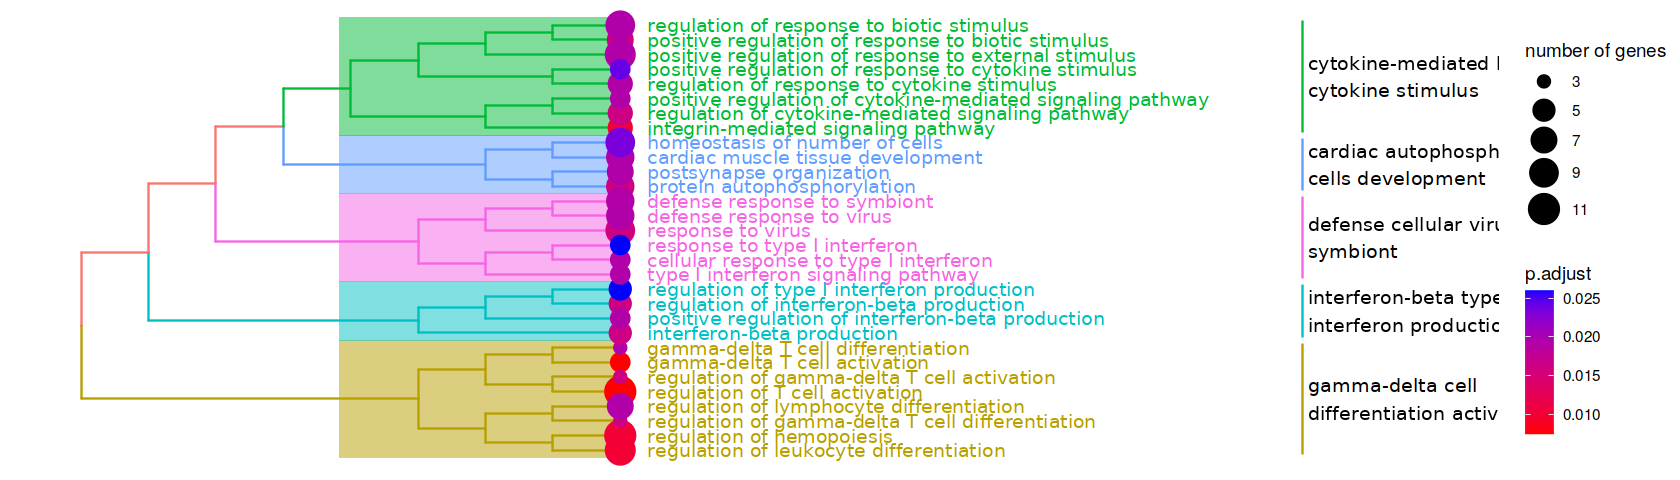

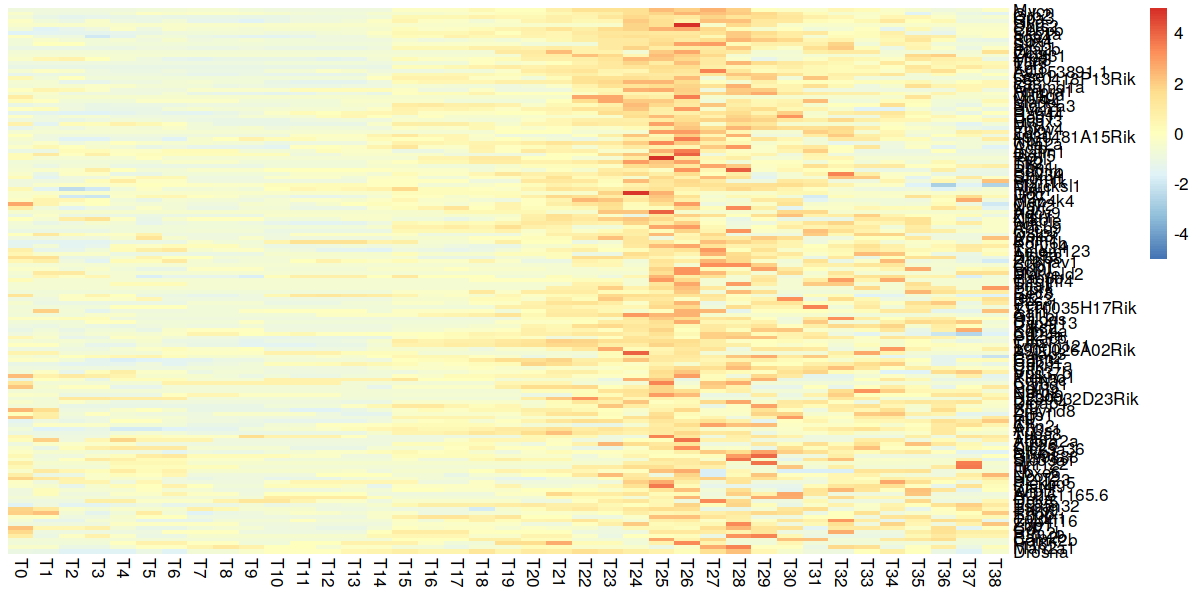

In [42]:
print('genes')
print(cat(c7.gene))

print('TFs')
print(cat(intersect(c7.gene, tf)))
o(14,4)
plot(c7.enrich.tree)

library(pheatmap)
o(10,5)
pheatmap(mat[c7.gene,], scale = 'row', 
         cluster_rows = F, cluster_cols = F, border_color=NA)

In [43]:
as.data.frame(c7.enrich.res)

ID        
GO:0050863 GO:0050863
GO:0046629 GO:0046629
GO:1902105 GO:1902105
GO:1903706 GO:1903706
GO:0007229 GO:0007229
GO:0032608 GO:0032608
GO:0032648 GO:0032648
GO:0002833 GO:0002833
GO:0045586 GO:0045586
GO:0046643 GO:0046643
GO:0046777 GO:0046777
GO:0001959 GO:0001959
GO:0009615 GO:0009615
GO:0051607 GO:0051607
GO:0140546 GO:0140546
GO:0060759 GO:0060759
GO:0042492 GO:0042492
GO:0002831 GO:0002831
GO:0045619 GO:0045619
GO:0001961 GO:0001961
GO:0048738 GO:0048738
GO:0032103 GO:0032103
GO:0099173 GO:0099173
GO:0032728 GO:0032728
GO:0060337 GO:0060337
GO:0071357 GO:0071357
GO:0048872 GO:0048872
GO:0060760 GO:0060760
GO:0032479 GO:0032479
GO:0034340 GO:0034340
⋮          ⋮         
GO:1903037 GO:1903037
GO:0071479 GO:0071479
GO:1903317 GO:1903317
GO:0050727 GO:0050727
GO:0000302 GO:0000302
GO:0006482 GO:0006482
GO:0008214 GO:0008214
GO:0007264 GO:0007264
GO:0000079 GO:0000079
GO:0050688 GO:0050688
GO:0050730 GO:0050730
GO:0070266 GO:0070266
GO:0071900 GO:0071900
GO:0050868 GO:0050868
GO:0030098 GO:0030098
GO:0034109 GO:0034109
GO:1904029 GO:1904029
GO:0045987 GO:0045987
GO:0002695 GO:0002695
GO:2000379 GO:2000379
GO:0045589 GO:0045589
GO:0060338 GO:0060338
GO:0031589 GO:0031589
GO:0014706 GO:0014706
GO:0022407 GO:0022407
GO:0097119 GO:0097119
GO:1900246 GO:1900246
GO:0007159 GO:0007159
GO:1903038 GO:1903038
GO:0045066 GO:0045066
           Description                                                            
GO:0050863 regulation of T cell activation                                        
GO:0046629 gamma-delta T cell activation                                          
GO:1902105 regulation of leukocyte differentiation                                
GO:1903706 regulation of hemopoiesis                                              
GO:0007229 integrin-mediated signaling pathway                                    
GO:0032608 interferon-beta production                                             
GO:0032648 regulation of interferon-beta production                               
GO:0002833 positive regulation of response to biotic stimulus                     
GO:0045586 regulation of gamma-delta T cell differentiation                       
GO:0046643 regulation of gamma-delta T cell activation                            
GO:0046777 protein autophosphorylation                                            
GO:0001959 regulation of cytokine-mediated signaling pathway                      
GO:0009615 response to virus                                                      
GO:0051607 defense response to virus                                              
GO:0140546 defense response to symbiont                                           
GO:0060759 regulation of response to cytokine stimulus                            
GO:0042492 gamma-delta T cell differentiation                                     
GO:0002831 regulation of response to biotic stimulus                              
GO:0045619 regulation of lymphocyte differentiation                               
GO:0001961 positive regulation of cytokine-mediated signaling pathway             
GO:0048738 cardiac muscle tissue development                                      
GO:0032103 positive regulation of response to external stimulus                   
GO:0099173 postsynapse organization                                               
GO:0032728 positive regulation of interferon-beta production                      
GO:0060337 type I interferon signaling pathway                                    
GO:0071357 cellular response to type I interferon                                 
GO:0048872 homeostasis of number of cells                                         
GO:0060760 positive regulation of response to cytokine stimulus                   
GO:0032479 regulation of type I interferon production                             
GO:0034340 response to type I interferon                                          
⋮          ⋮                                                              

## G2 (Peak T=31)

[1] "Genes:"
Eomes Ahsg Enho Nfkbid Sh3rf1 Gm43352 Gm5547 Strip2 Mdk Gm26782 Abca1 Etv5 Taco1os Wdr27 Rab11fip1 Gnaq Abhd18 Tab2 Parp4 H2-Eb1 Tlk1 Mvp Rnf150 Hexim1 Acadsb Il10ra Arid5b Mfhas1 Gramd1c Klrk1 Tmem8b Fos Ier5 Cln3 Itgal Lef1 Ctso 1700052K11Rik Rab22a 5830432E09Rik Cd28 Nrp2 Sik3 Siae Kif5a Il1r2 Trps1 Rab2b Ctsl Cd74 Nsmf Gprc5b Spry2 Lcp1 Ccr2 Selp Tpst2 Zfp606 Elane Zfyve16 Jup Elmod2 Zfp985 Kif13b Tmsb15b1 Tmco3 Kat6b Gm45669 Ciita Tob1 Ulk2 Lmbr1l Rfxank Notch2 AI987944 Ssh1 H2-Ab1 Klhl7 Pitpnc1 Gm13212 Ncoa7 Ube2h Klf2 Stab2 N4bp3 Polm Dlg4 Cd3g H2-Aa Pacsin1 Junb Tiam1 1810041H14Rik Sema4c Zfp607a Klf6 Jun Hsd17b11 Lonp2 Mindy4 Qrfp Tjp3 Cd27 Batf3 Gm43672 Cdk5 Gm11713 Gm16702 Ip6k1 Hmbox1 Rftn1 Sppl2a Meis1 Mbnl2 Gata2 Thra Sesn1 Tapbpl Pim2 Sun2 Prpsap2 Dusp1 Cflar Rtn4rl1 Ddhd1 Agl Shank1 Arhgap25 Taf1d Padi1 Eva1b Cryba4 Gm4208 Sox5 Dusp5 Add1 Sesn2 Gm12216 Ephb6 Gatsl3 Rasgrp4 Ak8 Smad7 Acot11 Filip1l Prss2 Rpgr Card6 Ctsc Wdr35 Mical1NULL
[1] "TFs:"
Eomes Etv5

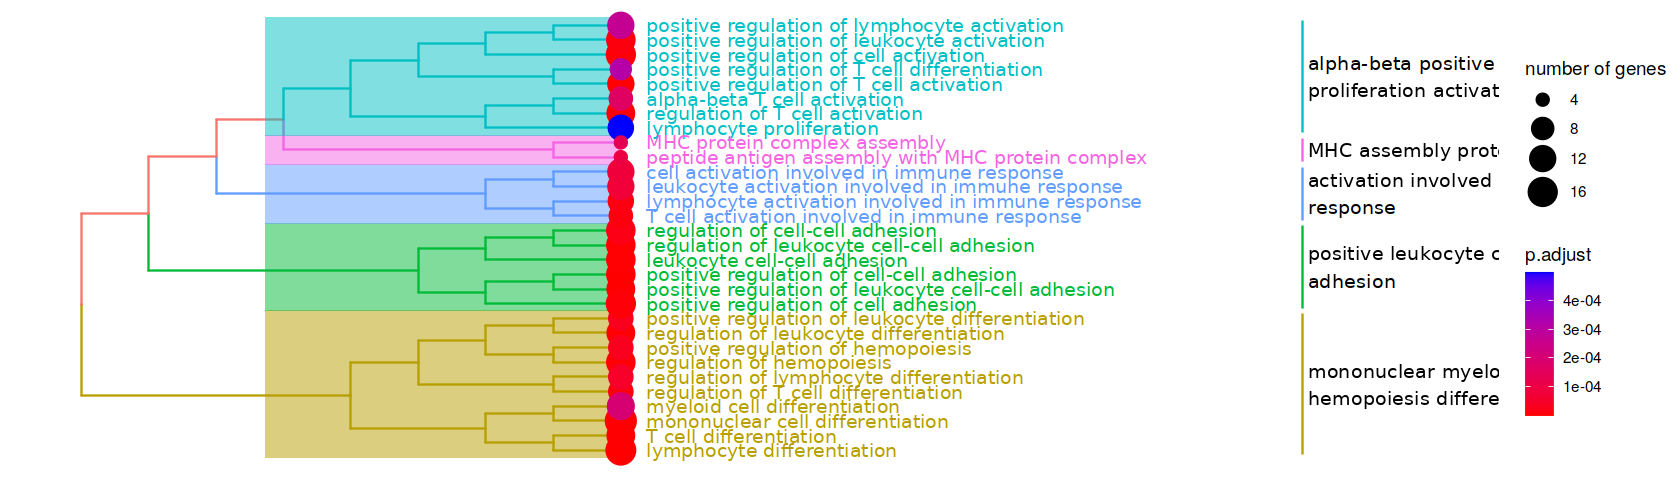

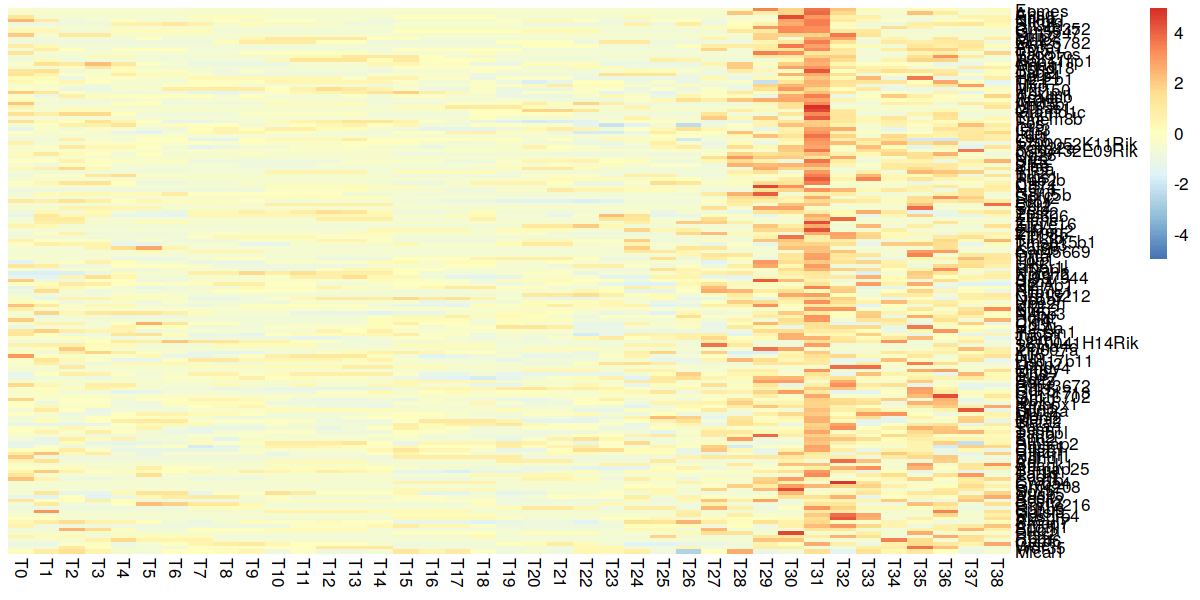

In [32]:
print('Genes:')
print(cat(c2.gene))

print('TFs:')
print(cat(intersect(c2.gene, tf)))

o(14,4)
plot(c2.enrich.tree)

library(pheatmap)
o(10,5)
pheatmap(mat[c2.gene,], scale = 'row', 
         cluster_rows = F, cluster_cols = F, border_color=NA)

In [33]:
as.data.frame(c2.enrich.res)

ID        
GO:1903131 GO:1903131
GO:1903039 GO:1903039
GO:0022409 GO:0022409
GO:0030098 GO:0030098
GO:1903037 GO:1903037
GO:0030217 GO:0030217
GO:0050870 GO:0050870
GO:0007159 GO:0007159
GO:1902105 GO:1902105
GO:0050867 GO:0050867
GO:1903706 GO:1903706
GO:0050863 GO:0050863
GO:0045785 GO:0045785
GO:0002696 GO:0002696
GO:0045580 GO:0045580
GO:0002286 GO:0002286
GO:0002285 GO:0002285
GO:0022407 GO:0022407
GO:1902107 GO:1902107
GO:1903708 GO:1903708
GO:0045619 GO:0045619
GO:0002366 GO:0002366
GO:0002263 GO:0002263
GO:0002501 GO:0002501
GO:0002396 GO:0002396
GO:0046631 GO:0046631
GO:0030099 GO:0030099
GO:0051251 GO:0051251
GO:0045582 GO:0045582
GO:0046651 GO:0046651
⋮          ⋮         
GO:0051098 GO:0051098
GO:0002718 GO:0002718
GO:0021543 GO:0021543
GO:0035970 GO:0035970
GO:0045060 GO:0045060
GO:0071241 GO:0071241
GO:0016241 GO:0016241
GO:0099565 GO:0099565
GO:0030111 GO:0030111
GO:0032092 GO:0032092
GO:0045185 GO:0045185
GO:0001819 GO:0001819
GO:0019083 GO:0019083
GO:0042088 GO:0042088
GO:0043618 GO:0043618
GO:0010970 GO:0010970
GO:0001704 GO:0001704
GO:0021761 GO:0021761
GO:0071248 GO:0071248
GO:0045664 GO:0045664
GO:0060395 GO:0060395
GO:0043383 GO:0043383
GO:0043923 GO:0043923
GO:0021879 GO:0021879
GO:0038202 GO:0038202
GO:0090288 GO:0090288
GO:0070372 GO:0070372
GO:1904036 GO:1904036
GO:0032535 GO:0032535
GO:0032970 GO:0032970
           Description                                                                      
GO:1903131 mononuclear cell differentiation                                                 
GO:1903039 positive regulation of leukocyte cell-cell adhesion                              
GO:0022409 positive regulation of cell-cell adhesion                                        
GO:0030098 lymphocyte differentiation                                                       
GO:1903037 regulation of leukocyte cell-cell adhesion                                       
GO:0030217 T cell differentiation                                                           
GO:0050870 positive regulation of T cell activation                                         
GO:0007159 leukocyte cell-cell adhesion                                                     
GO:1902105 regulation of leukocyte differentiation                                          
GO:0050867 positive regulation of cell activation                                           
GO:1903706 regulation of hemopoiesis                                                        
GO:0050863 regulation of T cell activation                                                  
GO:0045785 positive regulation of cell adhesion                                             
GO:0002696 positive regulation of leukocyte activation                                      
GO:0045580 regulation of T cell differentiation                                             
GO:0002286 T cell activation involved in immune response                                    
GO:0002285 lymphocyte activation involved in immune response                                
GO:0022407 regulation of cell-cell adhesion                                                 
GO:1902107 positive regulation of leukocyte differentiation                                 
GO:1903708 positive regulation of hemopoiesis                                               
GO:0045619 regulation of lymphocyte differentiation                                         
GO:0002366 leukocyte activation involved in immune response                                 
GO:0002263 cell activation involved in immune response                                      
GO:0002501 peptide antigen assembly with MHC protein complex                                
GO:0002396 MHC protein complex assembly                                                     
GO:0046631 alpha-beta T cell activation                                                     
GO:0030099 myeloid cell differentiation                                                     
GO:0051251 positive regulation of lymphocyt

## G3 (Peak T=36)

[1] "Genes:"
Zbtb16 Gsn Dok2 Gata3 H2-D1 Rora Prr13 Gimap5 Ypel3 Bcl2 Tox2 Ddit4 Tox Ctsw Gnai3 Clec2i Ccl5 Id2 Lpar6 Col9a3 Kdm7a Fam189b Pdcd1 Nkg7 Txnip Fcer1g Prss34 Arhgap45 Trbc1 Rab37 Pgam2 Zbtb20 Gimap6 Abtb1 Itgb2 Smpdl3a Pink1 Utrn Tcrg-C1 B2m Rxrg Vasp S100a10 Cd96 Gm26517 Ikzf2 Grina Vgll4 Tmem140 Sqstm1 Etv3 Btg1 Ablim1 Ccdc88b Gnpda2 Stard3nl Furin Vezf1 Hes1 Acot1 Fgf15 Dennd1c Nrgn Rxra H2-K1 Nipal1 Fgfbp3 Tgfbr2 Mov10 Xdh Lysmd3 Tcrg-C4 Htra3 Gstt2 Bcas1os2 Srgap3 Itm2c 2310001H17Rik Emid1 Exoc3l Gbp2 Tnfrsf9 Bcas1 Tnni1 Bcor Tcp11l2 Aak1 Rcn3 Mllt3 Pcmtd2 Ccdc125 Dcaf7 Lcp2 Prelid2 Trim12a Ormdl3 Gm26793 Ankrd16 Tprgl Sla Chd2 Batf Ngly1 Sgk1 Card11 Arntl Kdm4b Rom1 Dapk2 Dtx3 Sppl2b Gm34964 Fbxo32 Zfp57 Lpxn Rapgef3 Cbarp Cnn2 Fbxo27 Fcgr3 AW112010 Tcta Cdan1 Trbc2 Mir142hg Ypel5 Lrrc52 Cxcr5 Selenop Jak1 Ogt Tle3 9330160F10Rik Ncoa3 Mfsd7a F8a Mcpt8 Cnrip1 Crot Plekha2 Gadd45a Kdsr 9230105E05Rik Fndc3a Lsp1 Izumo4 Arhgef1 Gbp8 Sirt2 Gfod1 Patj Gpr65 AI467606 Tcrg-V1

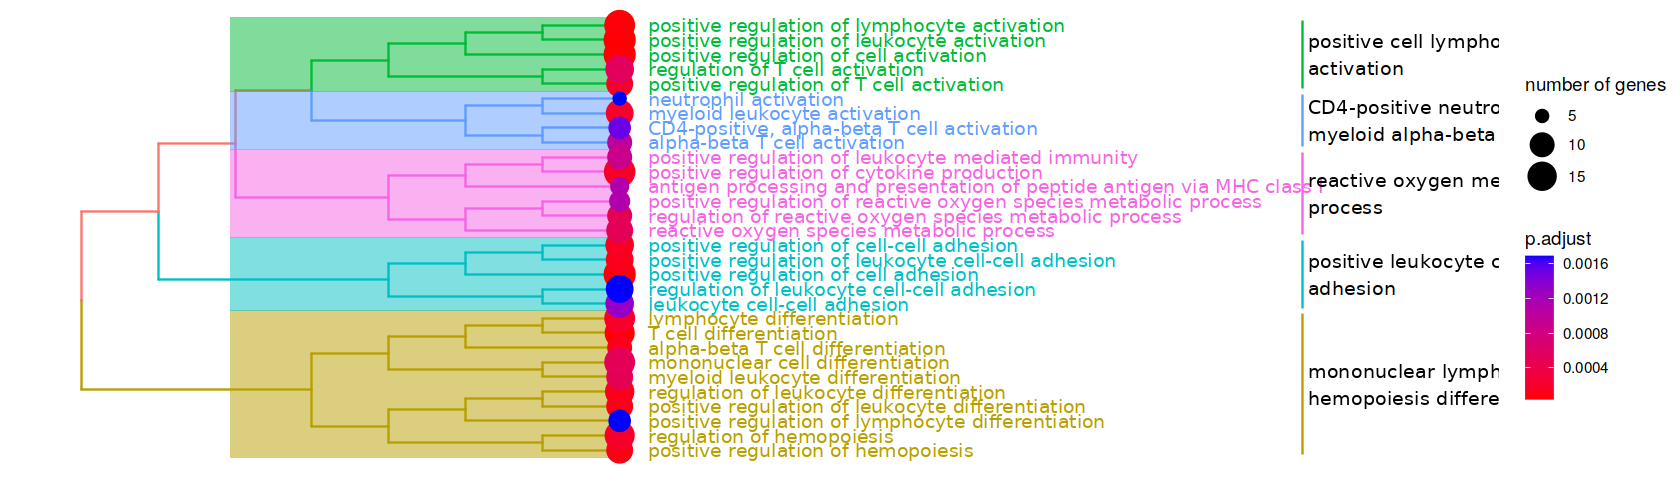

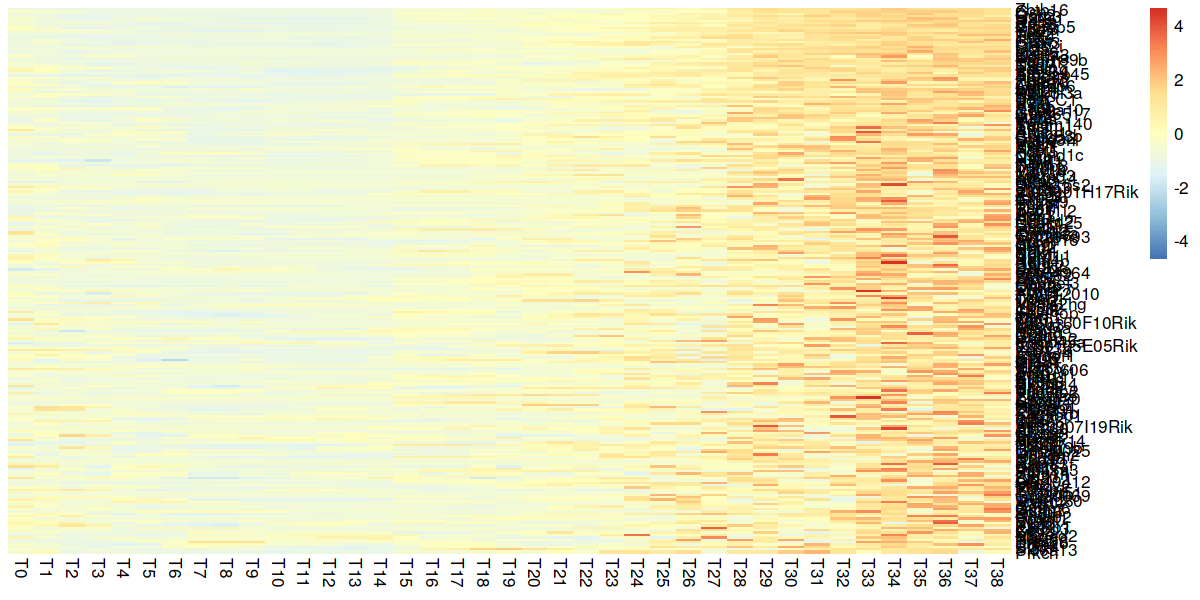

In [52]:
print('Genes:')
print(cat(c3.gene))

print('TFs:')
print(cat(intersect(c3.gene, tf)))

o(14,4)
plot(c3.enrich.tree)

library(pheatmap)
o(10,5)
pheatmap(mat[c3.gene,], scale = 'row', 
         cluster_rows = F, cluster_cols = F, border_color=NA)

In [54]:
as.data.frame(c3.enrich.res)


ID        
GO:0030217 GO:0030217
GO:0002696 GO:0002696
GO:0050867 GO:0050867
GO:0051251 GO:0051251
GO:0045785 GO:0045785
GO:1902107 GO:1902107
GO:1903708 GO:1903708
GO:1902105 GO:1902105
GO:0046632 GO:0046632
GO:1903039 GO:1903039
GO:0022409 GO:0022409
GO:0030098 GO:0030098
GO:0002274 GO:0002274
GO:0050870 GO:0050870
GO:1903706 GO:1903706
GO:0001819 GO:0001819
GO:0002573 GO:0002573
GO:2000377 GO:2000377
GO:0072593 GO:0072593
GO:1903131 GO:1903131
GO:0050863 GO:0050863
GO:0002705 GO:0002705
GO:0046631 GO:0046631
GO:0002474 GO:0002474
GO:2000379 GO:2000379
GO:0007159 GO:0007159
GO:0035710 GO:0035710
GO:1903037 GO:1903037
GO:0045621 GO:0045621
GO:0042119 GO:0042119
⋮          ⋮         
GO:0070988 GO:0070988
GO:0001655 GO:0001655
GO:0032673 GO:0032673
GO:0043372 GO:0043372
GO:0001823 GO:0001823
GO:0032613 GO:0032613
GO:0050854 GO:0050854
GO:0002709 GO:0002709
GO:0001822 GO:0001822
GO:0090398 GO:0090398
GO:0033032 GO:0033032
GO:1903901 GO:1903901
GO:0006898 GO:0006898
GO:0034446 GO:0034446
GO:0070665 GO:0070665
GO:0051091 GO:0051091
GO:1902106 GO:1902106
GO:0001765 GO:0001765
GO:0002361 GO:0002361
GO:0002866 GO:0002866
GO:0003149 GO:0003149
GO:0045955 GO:0045955
GO:0070544 GO:0070544
GO:0043270 GO:0043270
GO:0001913 GO:0001913
GO:0046651 GO:0046651
GO:0010522 GO:0010522
GO:0045920 GO:0045920
GO:0090322 GO:0090322
GO:1901020 GO:1901020
           Description                                                              
GO:0030217 T cell differentiation                                                   
GO:0002696 positive regulation of leukocyte activation                              
GO:0050867 positive regulation of cell activation                                   
GO:0051251 positive regulation of lymphocyte activation                             
GO:0045785 positive regulation of cell adhesion                                     
GO:1902107 positive regulation of leukocyte differentiation                         
GO:1903708 positive regulation of hemopoiesis                                       
GO:1902105 regulation of leukocyte differentiation                                  
GO:0046632 alpha-beta T cell differentiation                                        
GO:1903039 positive regulation of leukocyte cell-cell adhesion                      
GO:0022409 positive regulation of cell-cell adhesion                                
GO:0030098 lymphocyte differentiation                                               
GO:0002274 myeloid leukocyte activation                                             
GO:0050870 positive regulation of T cell activation                                 
GO:1903706 regulation of hemopoiesis                                                
GO:0001819 positive regulation of cytokine production                               
GO:0002573 myeloid leukocyte differentiation                                        
GO:2000377 regulation of reactive oxygen species metabolic process                  
GO:0072593 reactive oxygen species metabolic process                                
GO:1903131 mononuclear cell differentiation                                         
GO:0050863 regulation of T cell activation                                          
GO:0002705 positive regulation of leukocyte mediated immunity                       
GO:0046631 alpha-beta T cell activation                                             
GO:0002474 antigen processing and presentation of peptide antigen via MHC class I   
GO:2000379 positive regulation of reactive oxygen species metabolic process         
GO:0007159 leukocyte cell-cell adhesion                                             
GO:0035710 CD4-positive, alpha-beta T cell activation                               
GO:1903037 regulation of leukocyte cell-cell adhesion                               
GO:0045621 positive regulation of lymphocyte differentiation                        
GO:0042119 neutrophil activation                                                    
⋮          ⋮

## G1 (Peak T=38)

[1] "Genes:"
Cxcr6 Ckb Il7r Arg1 AC163354.1 Plin3 Ltb Tnfrsf1a Cacna1e Igfbp7 Gm6598 Hmgn3 Chad Ikzf3 Dennd4c Gm17745 Pitpnm1 Rorc Ccdc189 Prrt1 Cerk Gpr183 Il18r1 Gm26532 Maf Lmo4 1700113H08Rik Fam129a Gm15417 Ppt2 2610044O15Rik8 Eng Icos Slc16a3 Adam8 Clnk Ecm1 Ubash3b Xlr4a Itpr2 Dnase1l1 Dkk3 Dok1 Skap1 Tmsb15a Ppm1l Gprin3 Slc6a20b Fah Irak2 Ehbp1l1 4933424M12Rik Spock2 Thy1 Zbtb7b Xlr4c Zfp952 Traf1 Il17re Tnfsf14 Spink4 Il27ra Inpp1 Cdc42ep3 Wdr86 Cd9 Bmp4 Eya2 Fchsd2 Togaram2 Rgs14 Trib2 Tlr12 Osbpl5 Anxa1 Gstm1 Ets1 Nrip1 Tmem131 Shtn1 Eps15 Relb Trp53inp1 Rundc1 Aatk Agpat3 Fsd1 Cdc14a Lipa Arhgef28 Zfp36l1 Tecpr1 Lta Rcbtb2 Camk2d Tmem154 Cnnm2 Gm37494 Angptl2 Aldoc Muc1 Hk2 Cited2 AC147041.1 Dll1 Map4 St6galnac5 Fnbp1 Tktl1 1810011H11Rik Gpr18 Wdr62 Retreg3 Phip Arhgap9 Rinl Usp30 Tnfaip3 Eml4 Mgst1 Prr7 Susd2 H2-Oa Mettl27 Zfp740 Mylk3 Smco4 Emc9 Dpy19l3 Zbtb38 Aldh2 Txk Pkp3 Ifngr1 Cym Gna13 Gm9856 Pik3cd D730003I15Rik Cd82 Gm973 Lag3 Itm2b Prkcq Zc3h12a S100a4 AB124611 U

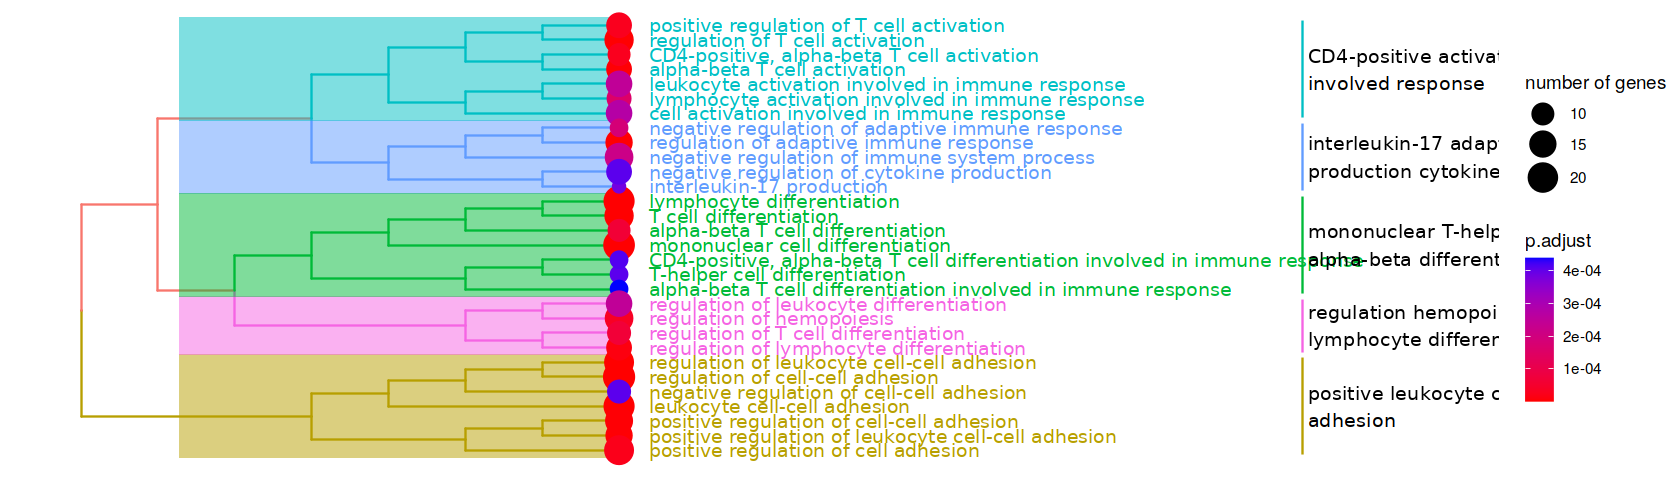

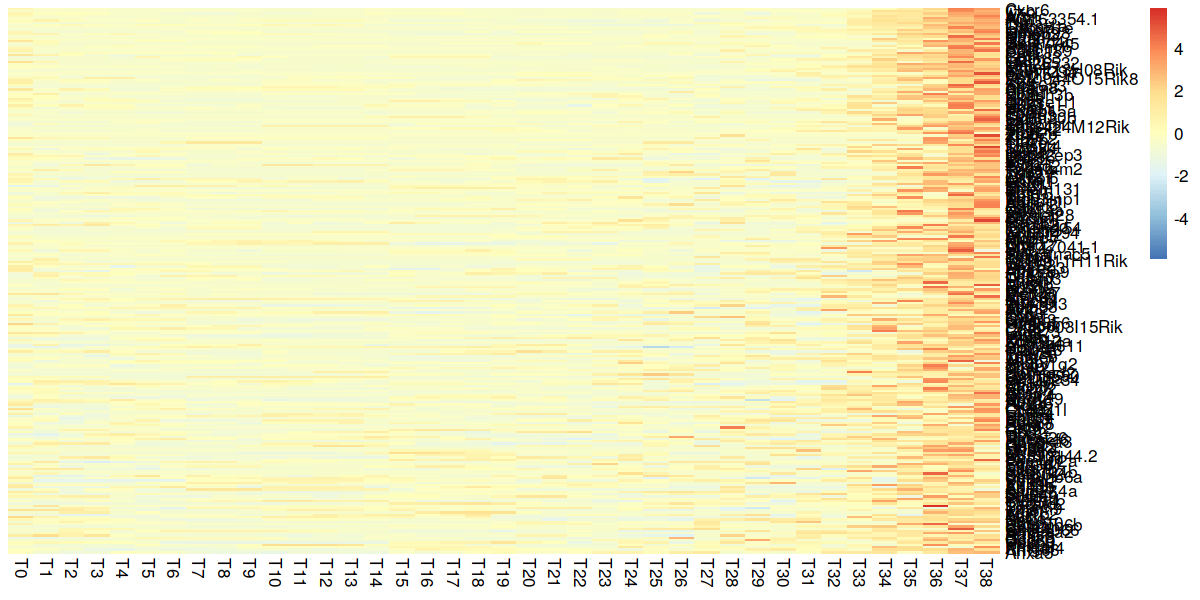

In [50]:
print('Genes:')
print(cat(c1.gene))

print('TFs:')
print(cat(intersect(c1.gene, tf)))

o(14,4)
plot(c1.enrich.tree)

library(pheatmap)
o(10,5)
pheatmap(mat[c1.gene,], scale = 'row', 
         cluster_rows = F, cluster_cols = F, border_color=NA)



In [51]:
as.data.frame(c1.enrich.res)

ID        
GO:0007159 GO:0007159
GO:0022407 GO:0022407
GO:1903037 GO:1903037
GO:0030217 GO:0030217
GO:0030098 GO:0030098
GO:1903131 GO:1903131
GO:0050863 GO:0050863
GO:0002819 GO:0002819
GO:1903039 GO:1903039
GO:0022409 GO:0022409
GO:0046631 GO:0046631
GO:0045619 GO:0045619
GO:0045785 GO:0045785
GO:0050870 GO:0050870
GO:0035710 GO:0035710
GO:1903706 GO:1903706
GO:0046632 GO:0046632
GO:0045580 GO:0045580
GO:0002285 GO:0002285
GO:0002820 GO:0002820
GO:0002683 GO:0002683
GO:1902105 GO:1902105
GO:0002366 GO:0002366
GO:0002263 GO:0002263
GO:0032620 GO:0032620
GO:0042093 GO:0042093
GO:0001818 GO:0001818
GO:0022408 GO:0022408
GO:0002294 GO:0002294
GO:0002293 GO:0002293
⋮          ⋮         
GO:0060401 GO:0060401
GO:0030099 GO:0030099
GO:0046639 GO:0046639
GO:0010631 GO:0010631
GO:0002718 GO:0002718
GO:0050878 GO:0050878
GO:0097553 GO:0097553
GO:0090132 GO:0090132
GO:0001938 GO:0001938
GO:0090130 GO:0090130
GO:0002068 GO:0002068
GO:0002313 GO:0002313
GO:0033081 GO:0033081
GO:0045598 GO:0045598
GO:0001947 GO:0001947
GO:2001237 GO:2001237
GO:0045661 GO:0045661
GO:2000401 GO:2000401
GO:0070227 GO:0070227
GO:0002825 GO:0002825
GO:0003416 GO:0003416
GO:0072539 GO:0072539
GO:0002764 GO:0002764
GO:0072676 GO:0072676
GO:0060349 GO:0060349
GO:0071375 GO:0071375
GO:0030193 GO:0030193
GO:0032869 GO:0032869
GO:0051480 GO:0051480
GO:0010634 GO:0010634
           Description                                                                
GO:0007159 leukocyte cell-cell adhesion                                               
GO:0022407 regulation of cell-cell adhesion                                           
GO:1903037 regulation of leukocyte cell-cell adhesion                                 
GO:0030217 T cell differentiation                                                     
GO:0030098 lymphocyte differentiation                                                 
GO:1903131 mononuclear cell differentiation                                           
GO:0050863 regulation of T cell activation                                            
GO:0002819 regulation of adaptive immune response                                     
GO:1903039 positive regulation of leukocyte cell-cell adhesion                        
GO:0022409 positive regulation of cell-cell adhesion                                  
GO:0046631 alpha-beta T cell activation                                               
GO:0045619 regulation of lymphocyte differentiation                                   
GO:0045785 positive regulation of cell adhesion                                       
GO:0050870 positive regulation of T cell activation                                   
GO:0035710 CD4-positive, alpha-beta T cell activation                                 
GO:1903706 regulation of hemopoiesis                                                  
GO:0046632 alpha-beta T cell differentiation                                          
GO:0045580 regulation of T cell differentiation                                       
GO:0002285 lymphocyte activation involved in immune response                          
GO:0002820 negative regulation of adaptive immune response                            
GO:0002683 negative regulation of immune system process                               
GO:1902105 regulation of leukocyte differentiation                                    
GO:0002366 leukocyte activation involved in immune response                           
GO:0002263 cell activation involved in immune response                                
GO:0032620 interleukin-17 production                                                  
GO:0042093 T-helper cell differentiation                                              
GO:0001818 negative regulation of cytokine production                                 
GO:0022408 negative regulation of cell-cell adhesion                                  
GO:0002294 CD4-positive, alpha-beta T cell differentiation involved in immune response
GO:0002293 alpha-beta T cell differen

# Summary

In [77]:
path.gene.modules <- list(
    "G4"= list(gene=c4.gene, enrichment=as.data.frame(c4.enrich.res), peakT=0),
    "G5"= list(gene=c5.gene, enrichment=as.data.frame(c5.enrich.res), peakT=10),
    "G6"= list(gene=c6.gene, enrichment=as.data.frame(c6.enrich.res), peakT=18),
    "G7"= list(gene=c7.gene, enrichment=as.data.frame(c7.enrich.res), peakT=26),
    "G2"= list(gene=c2.gene, enrichment=as.data.frame(c2.enrich.res), peakT=31),
    "G3"= list(gene=c3.gene, enrichment=as.data.frame(c3.enrich.res), peakT=36),
    "G1"= list(gene=c1.gene, enrichment=as.data.frame(c1.enrich.res), peakT=38)
)
names(path.gene.modules)

[1] "G4" "G5" "G6" "G7" "G2" "G3" "G1"

In [368]:
saveRDS(path.gene.modules, file = '221122-ABM.Mfuzz.gene.modules.rds')

In [151]:
goi.abm <- c(
    path.gene.modules[['G4']]$enrichment %>% filter(ID %in% terms.oi$go) %>%
    pull(geneID) %>% strsplit('/') %>% unlist %>% unique,

    path.gene.modules[['G5']]$enrichment %>% filter(ID %in% terms.oi$go) %>%
    pull(geneID) %>% strsplit('/') %>% unlist %>% unique,

    path.gene.modules[['G7']]$enrichment %>% filter(ID %in% terms.oi$go) %>%
    pull(geneID) %>% strsplit('/') %>% unlist %>% unique,

    path.gene.modules[['G2']]$enrichment %>% filter(ID %in% terms.oi$go) %>%
    pull(geneID) %>% strsplit('/') %>% unlist %>% unique,

    path.gene.modules[['G3']]$enrichment %>% filter(ID %in% terms.oi$go) %>%
    pull(geneID) %>% strsplit('/') %>% unlist %>% unique,

    path.gene.modules[['G1']]$enrichment %>% filter(ID %in% terms.oi$go) %>%
    pull(geneID) %>% strsplit('/') %>% unlist %>% unique
)


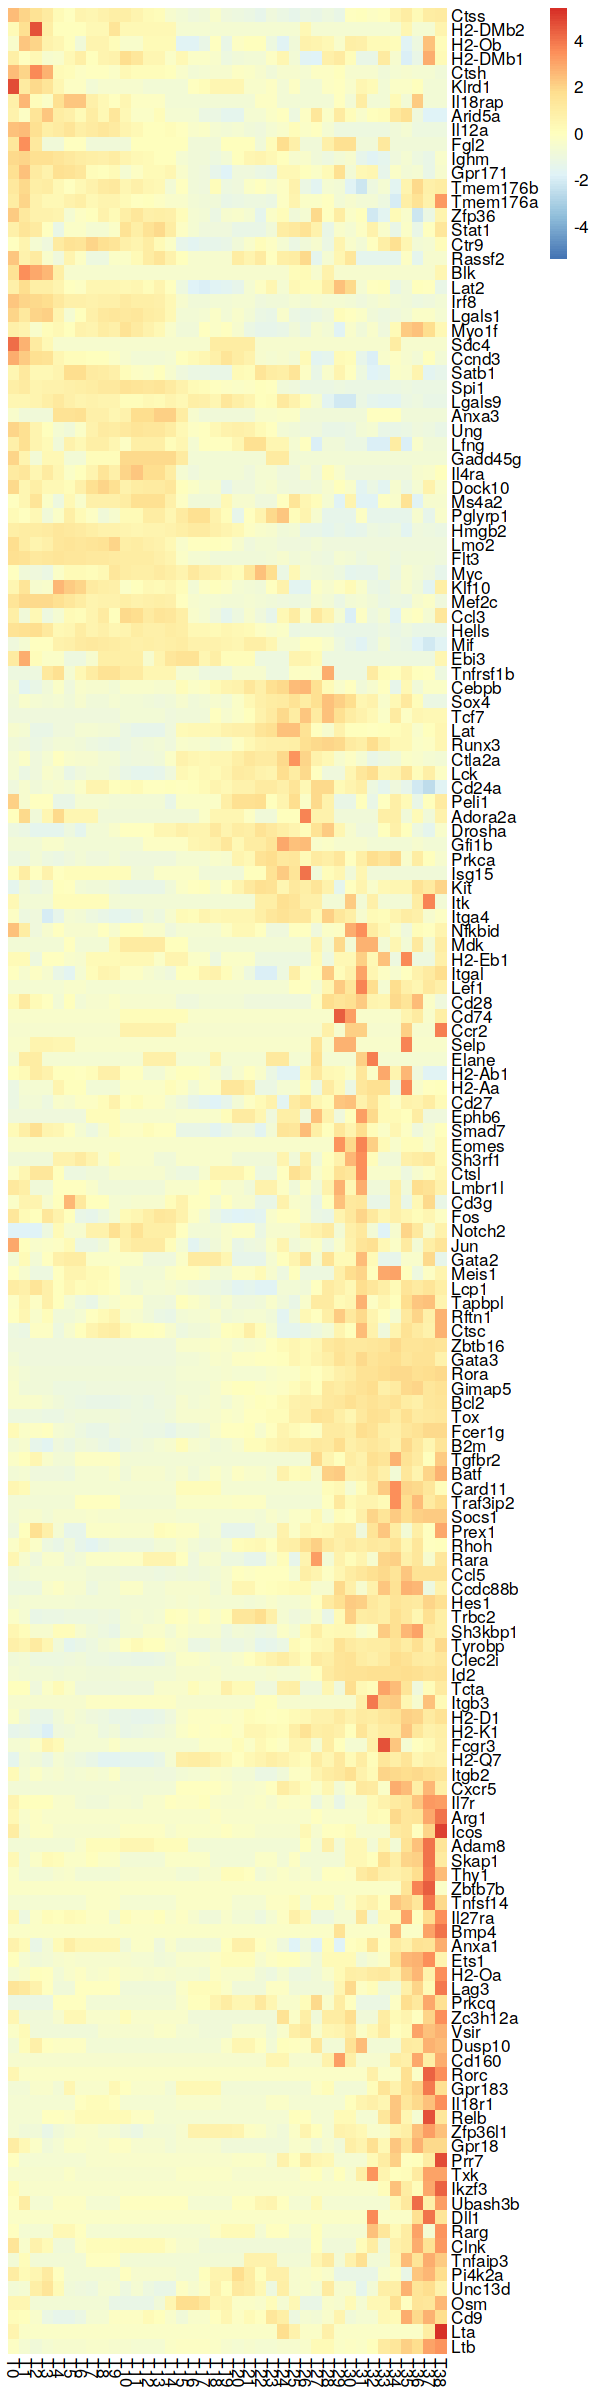

In [152]:
library(pheatmap)
o(5,20)
pheatmap(mat[goi.abm,], scale = 'row', 
         cluster_rows = F, cluster_cols = F, border_color=NA)

In [153]:
saveRDS(goi.abm, file='221122-ABM.GOselected.genes.rds')

In [155]:
goi.abm = readRDS('221122-ABM.GOselected.genes.rds')
goi.fl = readRDS('221122-FL.GOselected.genes.rds')
goi.common= intersect(goi.abm, goi.fl)
goi.abm.specific = setdiff(goi.abm, goi.fl)
goi.fl.specific  = setdiff(goi.fl, goi.abm)

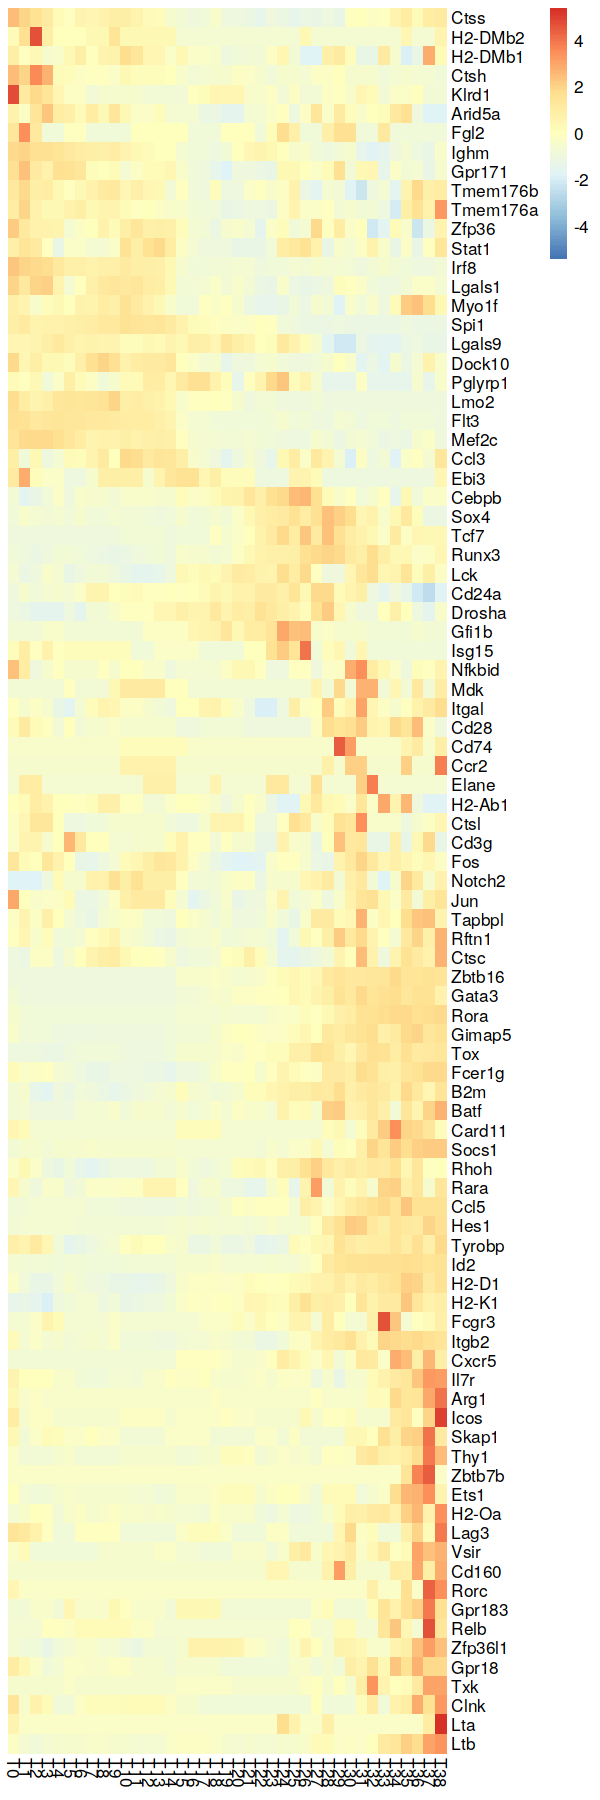

In [157]:
library(pheatmap)
o(5,15)
pheatmap( mat[goi.common,], scale = 'row', 
         cluster_rows = F, cluster_cols = F, border_color=NA)

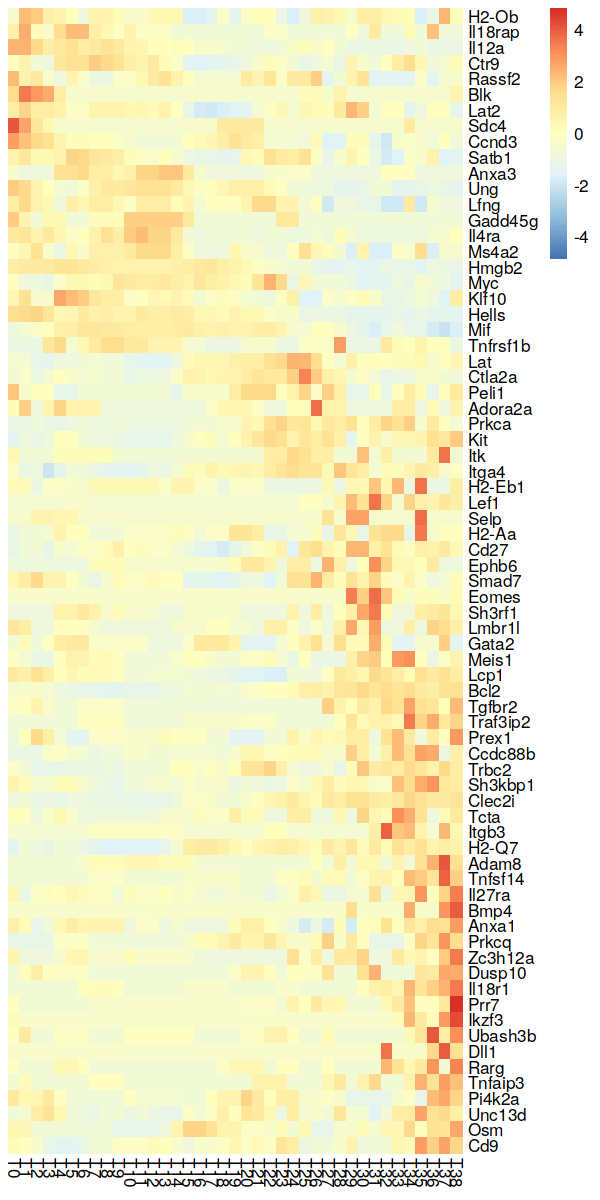

In [159]:
library(pheatmap)
o(5,10)
pheatmap(mat[goi.abm.specific,], scale='row', 
         cluster_rows = F, cluster_cols = F, border_color=NA)

# GSVA

## GOBP analysis

In [7]:
library(pheatmap)
expr = read.csv('./221112-ABM-ILCprimed-PathExpr.csv', row.names = 1)
colnames(expr) <- paste("T",0:(ncol(mat)-1), sep='')


In [237]:
library(msigdbr)
library(dplyr)
m_gene_sets = msigdbr(species = "mouse", category = "C5", subcategory = 'BP')

df <- m_gene_sets %>% dplyr::select(gene_symbol,gs_exact_source) %>% 
        filter(gs_exact_source %in% terms.oi$go) %>% 
        filter(gene_symbol %in% rownames(expr))%>%
        group_by(gs_exact_source) %>%
        summarise(genes = paste(gene_symbol, collapse=", "))

term2genes <- strsplit(df$genes, ', ')
names(term2genes)<-df$gs_exact_source

In [299]:
term2genes

$`GO:0002292`
 [1] "Anxa1"   "Atp7a"   "Batf"    "Bcl3"    "Bcl6"    "Cd46"    "Clec4d" 
 [8] "Clec4e"  "Cracr2a" "Entpd7"  "Eomes"   "Fcer1g"  "Fgl2"    "Foxp1"  
[15] "Gata3"   "Gpr183"  "H2-Eb1"  "Hlx"     "Hmgb1"   "Il12rb1" "Il18"   
[22] "Il18r1"  "Il2"     "Il4"     "Il4ra"   "Il6"     "Il6ra"   "Jak3"   
[29] "Lef1"    "Lgals9"  "Ly9"     "Malt1"   "Mtor"    "Myb"     "Nfkbid" 
[36] "Nfkbiz"  "Rara"    "Rc3h1"   "Rc3h2"   "Relb"    "Ripk2"   "Rora"   
[43] "Rorc"    "Sema4a"  "Slamf6"  "Smad7"   "Socs5"   "Spn"     "Stat3"  
[50] "Stat6"   "Tbx21"   "Tmem98"  "Tsc1"    "Zbtb7b"  "Zc3h12a" "Zfpm1"  

$`GO:0002460`
  [1] "Ada"      "Adam17"   "Ahr"      "Anxa1"    "Aplf"     "Arg1"    
  [7] "Arid5a"   "Atad5"    "B2m"      "Bach2"    "Batf"     "Bcl10"   
 [13] "Bcl3"     "Bcl6"     "Btk"      "C1qbp"    "C1rl"     "C2"      
 [19] "C8g"      "Card9"    "Ccr2"     "Ccr6"     "Cd1d1"    "Cd226"   
 [25] "Cd27"     "Cd274"    "Cd28"     "Cd4"      "Cd46"     "Cd74"    
 [31] "Cd81"     "Cd8a"     "Ceacam1"  "Clcf1"    "Clu"      "Cr1l"    
 [37] "Cr1l"     "Cracr2a"  "Csf2rb2"  "Ctsc"     "Ctsh"     "Dennd1b" 
 [43] "Dusp22"   "Ebi3"     "Entpd7"   "Ephb2"    "Ercc1"    "Exo1"    
 [49] "Exosc3"   "Fadd"     "Fbxo38"   "Fcer1g"   "Fcgr2b"   "Fut7"    
 [55] "Gapt"     "Gata3"    "Gnl1"     "Havcr2"   "Hfe"      "H2-Q7"   
 [61] "H2-D1"    "H2-Q7"    "H2-DMa"   "H2-DMb1"  "H2-Oa"    "H2-Ob"   
 [67] "H2-Aa"    "H2-Aa"    "H2-Ab1"   "H2-Ab1"   "H2-Eb1"   "H2-Eb1"  
 [73] "H2-T23"   "H2-M3"    "H2-M3"    "H2-Q7"    "Hlx"      "Hmces"   
 [79] "Hmgb1"    "Hprt"     "Hras"     "Hspd1"    "Icam1"    "Igha"    
 [85] "Igha"     "Ighm"     "Iglc1"    "Iglc1"    "Iglc1"    "Iglc1"   
 [91] "Il12a"    "Il12rb1"  "Il17ra"   "Il18"     "Il18r1"   "Il1r1"   
 [97] "Il1rl1"   "Il2"      "Il21r"    "Il27ra"   "Il4"      "Il4ra"   
[103] "Il6"      "Il6ra"    "Il7r"     "Il9r"     "Inpp5d"   "Irf7"    
[109] "Jak3"     "Kdm5d"    "Klhl6"    "Klrd1"    "Kmt5b"    "Kmt5c"   
[115] "Lef1"     "Lig4"     "Lta"      "Ly9"      "Mad2l2"   "Malt1"   
[121] "Map3k7"   "Mef2c"    "Mlh1"     "Mr1"      "Msh2"     "Msh6"    
[127] "Mtor"     "Myo1g"    "Nbn"      "Nckap1l"  "Ndfip1"   "Nfkb2"   
[133] "Nfkbid"   "Nfkbiz"   "Nlrp10"   "Notch1"   "Nsd2"     "P2rx7"   
[139] "Parp3"    "Paxip1"   "Phb"      "Pkn1"     "Pla2g4a"  "Ppp3cb"  
[145] "Prkcd"    "Prkcq"    "Ceacam1"  "Ptpn6"    "Ptprc"    "Pvr"     
[151] "Rab27a"   "Rc3h1"    "Rc3h2"    "Relb"     "Rftn1"    "Rif1"    
[157] "Ripk2"    "Ripk3"    "Rnf168"   "Rnf8"     "Rora"     "Rorc"    
[163] "Rsad2"    "Sash3"    "Sema4a"   "Sla2"     "Slamf6"   "Slc15a4" 
[169] "Smad7"    "Socs5"    "Spn"      "Stat3"    "Stat6"    "Stx7"    
[175] "Supt6"    "Swap70"   "Tbx21"    "Tcirg1"   "Tfrc"     "Tgfb1"   
[181] "Thoc1"    "Tmem98"   "Tnf"      "Tnfaip3"  "Tnfrsf1b" "Trp53bp1"
[187] "Traf2"    "Traf3ip2" "Traf6"    "Trbc1"    "Trbc2"    "Trbc1"   
[193] "Trbc2"    "Trpm4"    "Unc13d"   "Ung"      "Was"      "Xcl1"    
[199] "Zbtb1"    "Zbtb7b"   "Zc3h12a" 

$`GO:0002474`
 [1] "Abcb9"  "B2m"    "Calr"   "Erap1"  "Fcer1g" "Hfe"    "H2-Q7"  "H2-D1" 
 [9] "H2-Q7"  "H2-Q7"  "H2-T23" "H2-M3"  "H2-M3"  "H2-Q7"  "Ide"    "Ikbkb" 
[17] "Lnpep"  "Mfsd6"  "Mr1"    "Pdia3"  "Sar1b"  "Tap1"   "Tap2"   "Tapbp" 
[25] "Tapbpl"

$`GO:0002501`
 [1] "B2m"     "Calr"    "H2-DMa"  "H2-DMb1" "H2-Oa"   "H2-Ob"   "H2-Aa"  
 [8] "H2-Aa"   "H2-Ab1"  "H2-Ab1"  "H2-Eb1"  "H2-Eb1"  "Pdia3"   "Tapbp"  
[15] "Tapbpl" 

$`GO:0022408`
  [1] "Abl1"      "Adora2a"   "Akna"      "Akt1"      "Anxa1"     "Arg1"     
  [7] "Ass1"      "Bcl6"      "Bmp4"      "Casp3"     "Cbfb"      "Cblb"     
 [13] "Ccl25"     "Cd274"     "Cd300a"    "Cd74"      "Cd9"       "Ceacam1"  
 [19] "Cebpb"     "Cr1l"      "Ctsg"      "Dlg1"      "Dusp22"    "Epcam"    
 [25] "Fcgr2b"    "Fgl2"      "Fxyd5"     "Glmn"      "Gtpbp4"    "Havcr2"   
 [31] "Hfe"       "H2-Eb1"    "H2-M3"     "H2-Q7"     "Hlx"       "Hmgb1"    
 [37] "Il2"       "Il4"       "Il

In [287]:
library(GSVA)
gsva.result = gsva(as.matrix(expr), gset.idx.list = term2genes)

rownames(terms.oi) <-terms.oi$go
rownames(gsva.result )<- terms.oi[rownames(gsva.result), 'name']

Warning message in .filterFeatures(expr, method):
“23 genes with constant expression values throuhgout the samples.”
Warning message in .filterFeatures(expr, method):
“Since argument method!="ssgsea", genes with constant expression values are discarded.”


Estimating GSVA scores for 16 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



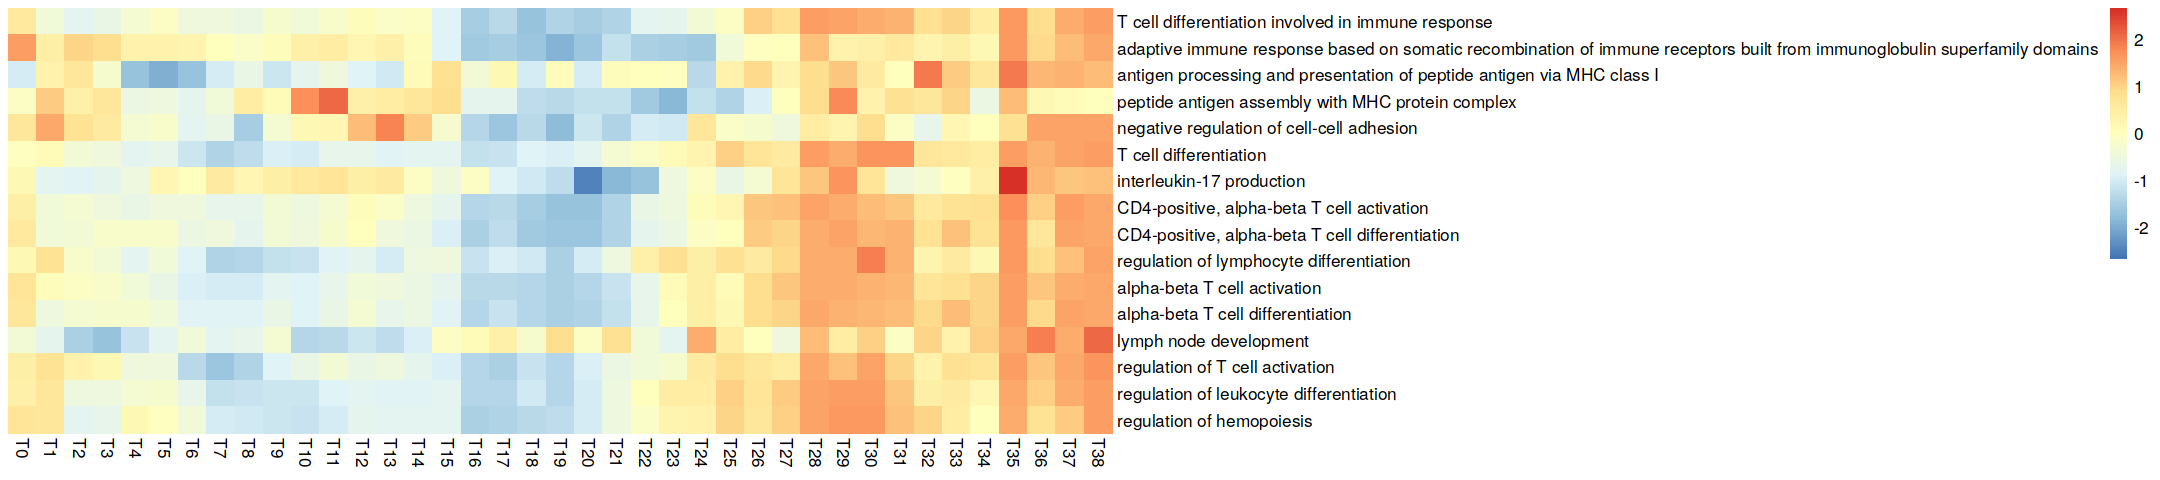

In [322]:
o(18,4)
pheatmap(gsva.result, cluster_rows = F, cluster_cols = F, scale = 'row')

## Gata3-Rorc-Notch

In [279]:
gata3 = read.csv('/home/csj/mywork/ilc/220517-pyscenic-grn/abm-Gata3Regulon.csv')$X0
rorc  = read.csv('/home/csj/mywork/ilc/220517-pyscenic-grn/abm-RorcRegulon.csv')$X0
#notch =c("Adam17","Aph1a","Aph1b","Cir1","Crebbp","Ctbp1","Ctbp2","Dtx1","Dtx2","Dtx3","Dtx3l","Dtx4","Dvl1","Dvl2","Dvl3","Hdac1","Hdac2","Hes1","Hes5","Kat2a","Kat2b","Lfng","Maml1","Maml3","Mfng","Ncor2","Ncstn","Notch1","Notch2","Notch3","Notch4","Numb","Numbl","Psen1","Psen2","Ptcra","Rbpj","Rbpjl","Rfng","Snw1","Tnf")
notch=c("Notch1","Notch2","Notch3","Notch4",'Furin','Psen2','Adam17','Dtx1','Dtx4','Rbpj')

gs2genes = list(
    "Gata3" = gata3,
    "Rorc" = rorc,
    'Notch' = notch    
)

gs2genes

$Gata3
[1] "Ahcyl2" "Tmsb4x" "Rora"   "Lpar6"  "Arg1"   "Lmo4"   "Junb"   "Ltb"   
[9] "Emb"   

$Rorc
  [1] "Gtpbp2"        "Nfia"          "Fli1"          "Lingo4"       
  [5] "Ahr"           "Syne1"         "Cap2"          "Slc11a2"      
  [9] "Sp6"           "S100a13"       "Akirin2"       "Map3k14"      
 [13] "Aagab"         "S100a3"        "Espn"          "Upp2"         
 [17] "Ets1"          "Hormad2"       "Rarg"          "Lmo4"         
 [21] "Tbc1d10c"      "Pde4b"         "Zfp827"        "Zfand6"       
 [25] "Sh3bp5"        "Camk4"         "Ppt2"          "Cxcr6"        
 [29] "Fam124b"       "Tgfbr3"        "Il23r"         "Emb"          
 [33] "Basp1"         "Cmtm6"         "Ccr6"          "Selenot"      
 [37] "Thra"          "9130401M01Rik" "Mprip"         "Epb41l2"      
 [41] "Zbtb20"        "Pde2a"         "Ahcyl2"        "Jak2"         
 [45] "Jun"           "Rora"          "Cym"           "Il12rb1"      
 [49] "Clcn3"         "Mmd"           "Msi2"          "Diaph1"       
 [53] "Sesn3"         "Plekho2"       "Shtn1"         "Rnf2"         
 [57] "Mgmt"          "Cdc42ep3"      "St6galnac4"    "1700012B07Rik"
 [61] "Ppp1r14b"      "Arntl"         "Utp18"         "Eif1b"        
 [65] "Rara"          "Iqsec1"        "Lgals8"        "Enpp4"        
 [69] "Rxrg"          "Kpnb1"         "Dnajb2"        "Ndst1"        
 [73] "Glb1"          "Chd2"          "Lpxn"          "Trp53inp1"    
 [77] "Kmt5b"         "Smox"          "Sh3kbp1"       "Mgea5"        
 [81] "Cited2"        "Trps1"         "Tmem140"       "Cast"         
 [85] "Fah"           "Cotl1"         "Il1rl1"        "Pxdc1"        
 [89] "Ankrd35"       "Il18r1"        "Arhgef28"      "Eya2"         
 [93] "Sorbs2"        "Lxn"           "Tdrkh"         "Phf21a"       
 [97] "Tspan14"       "Rpl37a"        "S100a10"       "Nr1d1"        
[101] "Cnn2"          "Art4"          "Tecpr1"        "Capn1"        
[105] "1700061F12Rik" "Pkn1"          "Rorc"          "Ccr2"         
[109] "Orc4"          "Adgrg5"        "Itk"           "Prickle1"     
[113] "Pea15a"        "Npas2"         "Ptp4a2"        "Tmem51"       
[117] "Uhrf2"         "Smco4"         "Txk"           "Il17re"       
[121] "Lonp2"         "Snx4"          "Sertad2"       "Ppfibp1"      
[125] "Nebl"          "Cd36"          "Adam12"        "S100a4"       
[129] "Pik3r1"        "Epc1"          "Kif21b"        "Pofut1"       
[133] "Gm15417"       "Rhoc"          "Gpr183"        "Bcl11b"       
[137] "Vamp5"         "Rims3"         "Rab11fip1"     "Lat"          
[141] "Gm5122"        "Coro1c"        "Csrnp1"        "Sirt7"        
[145] "Rhog"         

$Notch
 [1] "Notch1" "Notch2" "Notch3" "Notch4" "Furin"  "Psen2"  "Adam17" "Dtx1"  
 [9] "Dtx4"   "Rbpj"

In [280]:
# fill absent genes with zeroes 
inserted <- data.frame(matrix(0,nrow=length(setdiff(unname(unlist(gs2genes)),rownames(expr))), ncol=39))
rownames(inserted)<- setdiff(unname(unlist(gs2genes)), rownames(expr))
colnames(inserted)<- colnames(expr)
expr<- rbind(expr, inserted)

### gsva analysis

In [281]:
library(GSVA)
gsva.result.abm = gsva(as.matrix(expr), gset.idx.list = gs2genes, method='ssgsea')
write.csv(gsva.result.abm,   file='GSVA_abm_gata3-rorc-notch.csv')

Warning message in .filterFeatures(expr, method):
“45 genes with constant expression values throuhgout the samples.”


Estimating ssGSEA scores for 3 gene sets.
  |======================================================================| 100%



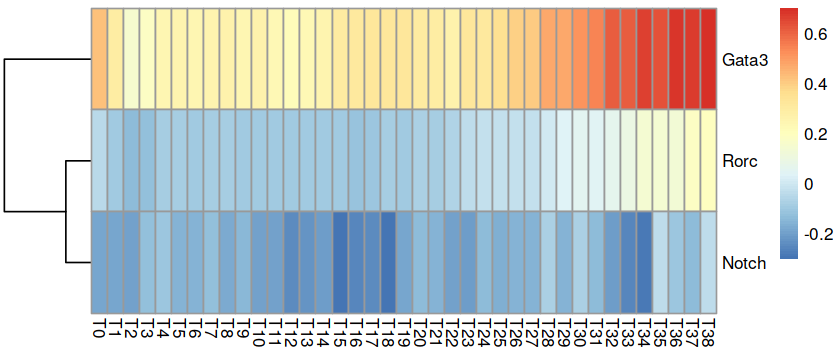

In [282]:
o(7,3)
pheatmap(gsva.result.abm, cluster_cols = F)

### aucell analysis

In [283]:
library("AUCell")
cells_rankings <- AUCell_buildRankings(as.matrix(expr), plotStats=F)
aucell.result.abm <- getAUC(AUCell_calcAUC(gs2genes, cells_rankings))
write.csv(aucell.result.abm, file='AUCell_abm_gata3-rorc-notch.csv')

Quantiles for the number of genes detected by cell: 
(Non-detected genes are shuffled at the end of the ranking. Keep it in mind when choosing the threshold for calculating the AUC).



    min      1%      5%     10%     50%    100% 
6735.00 6798.84 6905.70 6933.40 8083.00 8515.00 


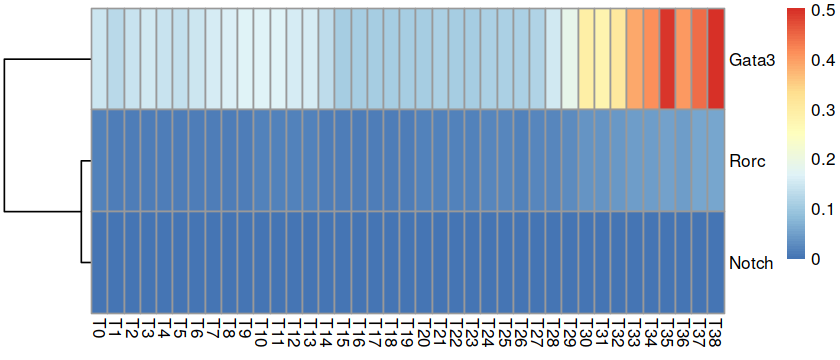

In [284]:
o(7,3)
pheatmap(aucell.result.abm, cluster_cols = F)

### gsva joint analysis

In [285]:
gsva.result.fl   = read.csv('./GSVA_fl_gata3-rorc-notch.csv', row.names = 1)
gsva.result.abm  = read.csv('./GSVA_abm_gata3-rorc-notch.csv', row.names = 1)

gsva.result.fl  = (gsva.result.fl - (-1))/2
gsva.result.abm = (gsva.result.abm - (-1))/2

In [286]:
gsva.result.flabmjoint = cbind(gsva.result.fl, gsva.result.abm)
rowmin= apply(gsva.result.flabmjoint, 1, min)
rowmax= apply(gsva.result.flabmjoint, 1, max)
gsva.result.flabmjoint = (gsva.result.flabmjoint - rowmin)/(rowmax-rowmin)
gsva.result.flabmjoint

T0         T1        T2         T3         T4         T5        
Gata3 0.04032348 0.0000000 0.08494424 0.07800955 0.05732472 0.04144014
Rorc  0.21050866 0.4153669 0.33750194 0.34289719 0.31796542 0.22370731
Notch 0.43073442 0.2463450 0.06268889 0.23218571 0.26138828 0.26230366
      T6         T7       T8        T9         ⋯ T29       T30       T31      
Gata3 0.03074573 0.109265 0.1762207 0.16847436 ⋯ 0.6990672 0.7483008 0.7867468
Rorc  0.37756692 0.222248 0.2307170 0.22715824 ⋯ 0.2715041 0.3084318 0.2970301
Notch 0.41123989 0.282260 0.1905425 0.01107839 ⋯ 0.7477544 0.9240798 0.8003337
      T32       T33       T34       T35       T36       T37       T38      
Gata3 0.8789352 0.8820866 0.9571710 0.9182041 0.9857432 0.9719228 1.0000000
Rorc  0.3219612 0.3801410 0.4510297 0.4552380 0.4482475 0.5282752 0.5443948
Notch 0.6426158 0.5551471 0.4968745 1.0000000 0.8485437 0.7901350 0.9947207

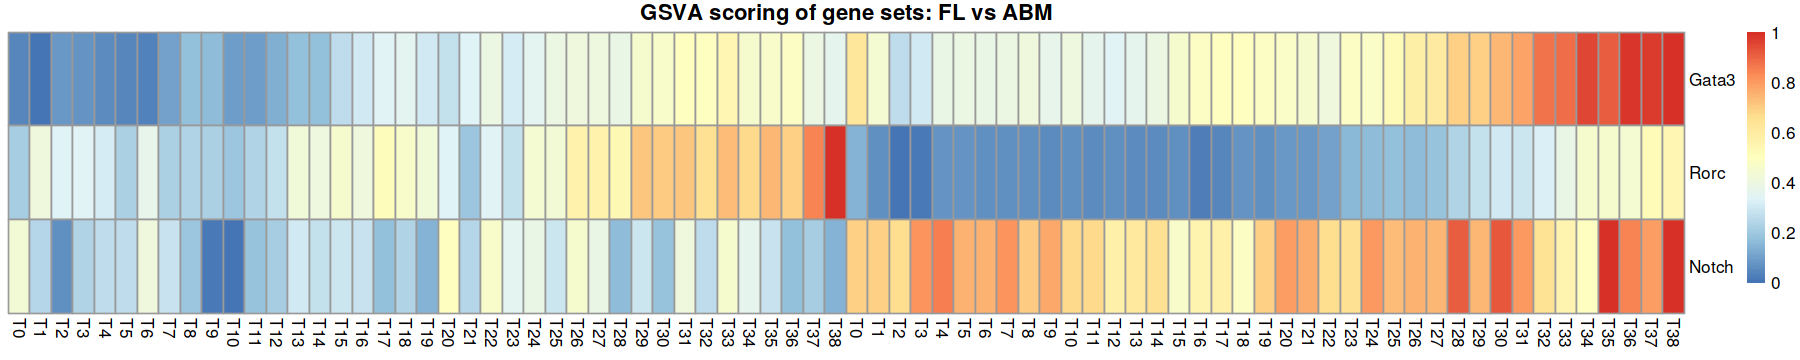

In [289]:
o(15,3)
pheatmap(gsva.result.flabmjoint,cluster_rows = F, cluster_cols = F, main='GSVA scoring of gene sets: FL vs ABM')

In [324]:
t(gsva.result.flabmjoint) %>% data.frame %>% mutate(group=c(rep('FL',39),rep('ABM',39)))

Gata3      Rorc       Notch      group
T0    0.04032348 0.2105087  0.43073442 FL   
T1    0.00000000 0.4153669  0.24634498 FL   
T2    0.08494424 0.3375019  0.06268889 FL   
T3    0.07800955 0.3428972  0.23218571 FL   
T4    0.05732472 0.3179654  0.26138828 FL   
T5    0.04144014 0.2237073  0.26230366 FL   
T6    0.03074573 0.3775669  0.41123989 FL   
T7    0.10926503 0.2222480  0.28226003 FL   
T8    0.17622073 0.2307170  0.19054249 FL   
T9    0.16847436 0.2271582  0.01107839 FL   
T10   0.09832534 0.1944817  0.00000000 FL   
T11   0.09209235 0.2388865  0.18484123 FL   
T12   0.13336876 0.2732764  0.21627973 FL   
T13   0.17482394 0.4288833  0.30687489 FL   
T14   0.17564676 0.4024959  0.27172086 FL   
T15   0.26940995 0.4517667  0.29901704 FL   
T16   0.30652400 0.4178718  0.28184944 FL   
T17   0.34430511 0.5138680  0.17987399 FL   
T18   0.35007503 0.4628524  0.23607840 FL   
T19   0.30096843 0.4246186  0.14555787 FL   
T20   0.27527884 0.3339304  0.49197348 FL   
T21   0.33032640 0.1959390  0.24200589 FL   
T22   0.39847282 0.3434255  0.46917712 FL   
T23   0.31643008 0.2792372  0.35370416 FL   
T24   0.35172111 0.4464542  0.38712792 FL   
T25   0.39983455 0.4393587  0.29007926 FL   
T26   0.41409103 0.5615694  0.45177764 FL   
T27   0.40816133 0.5641175  0.38247404 FL   
T28   0.38754962 0.5344390  0.16986159 FL   
T29   0.45196113 0.7198092  0.29490576 FL   
⋮     ⋮          ⋮          ⋮          ⋮    
T9.1  0.3762339  0.05625171 0.7790706  ABM  
T10.1 0.4099153  0.06702667 0.6795420  ABM  
T11.1 0.3662977  0.05674512 0.6784963  ABM  
T12.1 0.3406353  0.06230122 0.5763868  ABM  
T13.1 0.3670536  0.05884044 0.6183081  ABM  
T14.1 0.3907078  0.05473487 0.6510343  ABM  
T15.1 0.4576898  0.06582852 0.4604357  ABM  
T16.1 0.4820742  0.02572650 0.5544833  ABM  
T17.1 0.4969434  0.04690280 0.5716969  ABM  
T18.1 0.4971513  0.07256124 0.4806166  ABM  
T19.1 0.4868048  0.06649770 0.6915485  ABM  
T20.1 0.4710099  0.08620796 0.7905350  ABM  
T21.1 0.4510415  0.08430559 0.7636987  ABM  
T22.1 0.4123006  0.10584600 0.6633753  ABM  
T23.1 0.4898269  0.15543923 0.6541253  ABM  
T24.1 0.4726531  0.16934378 0.8020780  ABM  
T25.1 0.5265673  0.17647560 0.7365702  ABM  
T26.1 0.5850400  0.16881180 0.7533856  ABM  
T27.1 0.6036626  0.18063393 0.7452621  ABM  
T28.1 0.6964512  0.23112235 0.9139923  ABM  
T29.1 0.6990672  0.27150407 0.7477544  ABM  
T30.1 0.7483008  0.30843179 0.9240798  ABM  
T31.1 0.7867468  0.29703006 0.8003337  ABM  
T32.1 0.8789352  0.32196120 0.6426158  ABM  
T33.1 0.8820866  0.38014097 0.5551471  ABM  
T34.1 0.9571710  0.45102971 0.4968745  ABM  
T35.1 0.9182041  0.45523798 1.0000000  ABM  
T36.1 0.9857432  0.44824748 0.8485437  ABM  
T37.1 0.9719228  0.52827517 0.7901350  ABM  
T38.1 1.0000000  0.54439481 0.9947207  ABM

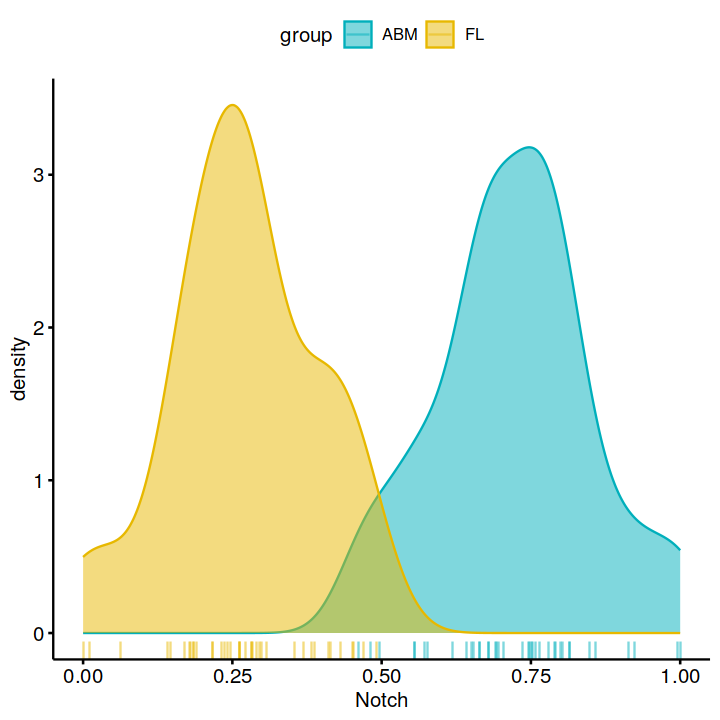

In [325]:


ggdensity(t(gsva.result.flabmjoint) %>% data.frame %>% mutate(group=c(rep('FL',39),rep('ABM',39))), 
          x = "Notch",rug = TRUE,
          color = "group", fill = "group",
          palette = c("#00AFBB", "#E7B800"))

### aucell joint analysis (unsuccessful)

In [290]:
aucell.result.fl  = read.csv('./AUCell_fl_gata3-rorc-notch.csv', row.names = 1)
aucell.result.abm = read.csv('./AUCell_abm_gata3-rorc-notch.csv', row.names = 1)


In [291]:
# join abm and fl
aucell.result.flabmjoint = cbind(aucell.result.fl, aucell.result.abm)
rowmin= apply(aucell.result.flabmjoint, 1, min)
rowmax= apply(aucell.result.flabmjoint, 1, max)
aucell.result.flabmjoint = (aucell.result.flabmjoint - rowmin)/(rowmax-rowmin)


In [292]:
aucell.result.flabmjoint

T0  T1         T2         T3           T4          T5         
Gata3   0 0.02755493 0.03603336 0.0009420487 0.001648585 0.004239219
Rorc    0 0.00000000 0.00000000 0.0000000000 0.000000000 0.000000000
Notch NaN        NaN        NaN          NaN         NaN         NaN
      T6          T7          T8          T9          ⋯ T29       T30      
Gata3 0.006358829 0.005652292 0.002826146 0.002355122 ⋯ 0.3178349 0.5407526
Rorc  0.000000000 0.000000000 0.000000000 0.000000000 ⋯ 0.1998775 0.2670391
Notch         NaN         NaN         NaN         NaN ⋯       NaN       NaN
      T31       T32       T33       T34       T35       T36       T37      
Gata3 0.5167034 0.5819137 0.7558080 0.8080688 0.9787257 0.7914194 0.8788290
Rorc  0.2900004 0.3057288 0.3451073 0.3435000 0.3827638 0.3533734 0.4445295
Notch       NaN       NaN       NaN       NaN       NaN       NaN       NaN
      T38      
Gata3 1.0000000
Rorc  0.4378707
Notch       NaN

In [293]:
o(15,3)
pheatmap(aucell.result.flabmjoint, cluster_cols = F, main='AUCell scoring of gene sets: FL vs ABM')

ERROR: Error in hclust(d, method = method): NA/NaN/Inf in foreign function call (arg 10)


In [298]:
gsva.result.flabmjoint[,40:78]

T0        T1        T2        T3         T4         T5         T6        
Gata3 0.6268628 0.4467032 0.2611732 0.30528473 0.38553435 0.39374292 0.38160822
Rorc  0.1464541 0.0652200 0.0000000 0.01415272 0.07246154 0.07857557 0.06228755
Notch 0.6956111 0.6901909 0.6639457 0.81458910 0.85846533 0.75817925 0.75043281
      T7         T8         T9         ⋯ T29       T30       T31      
Gata3 0.39893476 0.41579218 0.37623391 ⋯ 0.6990672 0.7483008 0.7867468
Rorc  0.06972115 0.06787411 0.05625171 ⋯ 0.2715041 0.3084318 0.2970301
Notch 0.81432608 0.70386860 0.77907061 ⋯ 0.7477544 0.9240798 0.8003337
      T32       T33       T34       T35       T36       T37       T38      
Gata3 0.8789352 0.8820866 0.9571710 0.9182041 0.9857432 0.9719228 1.0000000
Rorc  0.3219612 0.3801410 0.4510297 0.4552380 0.4482475 0.5282752 0.5443948
Notch 0.6426158 0.5551471 0.4968745 1.0000000 0.8485437 0.7901350 0.9947207

Warning message:
“Removed 2 rows containing non-finite values (`StatDensityTern()`).”
Warning message:
“Removed 1 rows containing non-finite values (`StatDensityTern()`).”


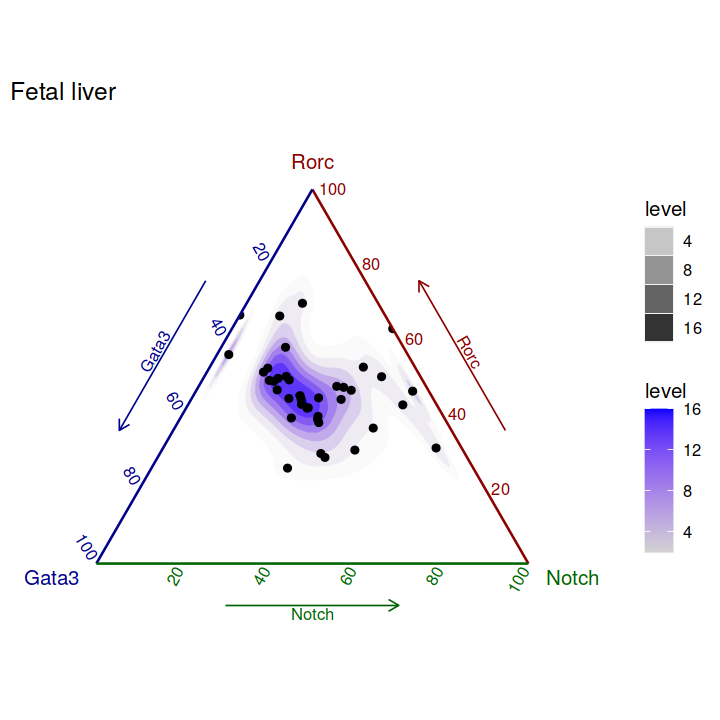

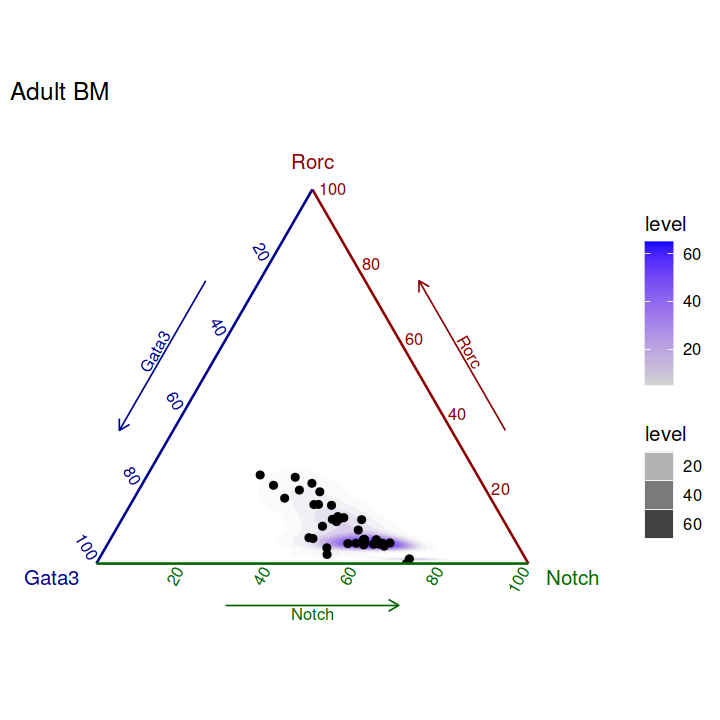

In [351]:
library(ggtern)
data<- as.data.frame(t(gsva.result.flabmjoint[,1:39]))
data$T =seq(0, nrow(data)-1)
set.seed(10)
plot <- ggtern(data = data,
               aes(Gata3, Rorc, Notch))
p.fl<- plot + stat_density_tern(geom = 'polygon',
                         n         = 100,
                         aes(fill  = ..level..,
                             alpha = ..level..)) +
  geom_point() + theme_rgbw() + 
  scale_fill_gradient(low = "lightgray",high = "blue")  +
  #guides(color = "none", fill = "none", alpha = "none")+
  labs(title = "Fetal liver")


library(ggtern)
data<- as.data.frame(t(gsva.result.flabmjoint[,40:78]))
data$T =seq(0, nrow(data)-1)
set.seed(10)

plot <- ggtern(data = data,
               aes(Gata3, Rorc, Notch))
p.abm<- plot + stat_density_tern(geom = 'polygon',
                         n         = 100,
                         aes(fill  = ..level..,
                             alpha = ..level..)) +
  geom_point() + theme_rgbw() +
  scale_fill_gradient(low = "lightgray",high = "blue")  +
  #guides(color = "none", fill = "none", alpha = "none")+
  labs(title = "Adult BM")

o(6,6)
p.fl
p.abm

In [352]:

pdf('Ternary-FL-notch.gata3.rorc.pdf', width=6, height = 6)
p.fl
dev.off()

pdf('Ternary-ABM-notch.gata3.rorc.pdf', width = 6, height = 6)
p.abm
dev.off()

Warning message:
“Removed 2 rows containing non-finite values (`StatDensityTern()`).”


png 
  2

Warning message:
“Removed 1 rows containing non-finite values (`StatDensityTern()`).”


png 
  2

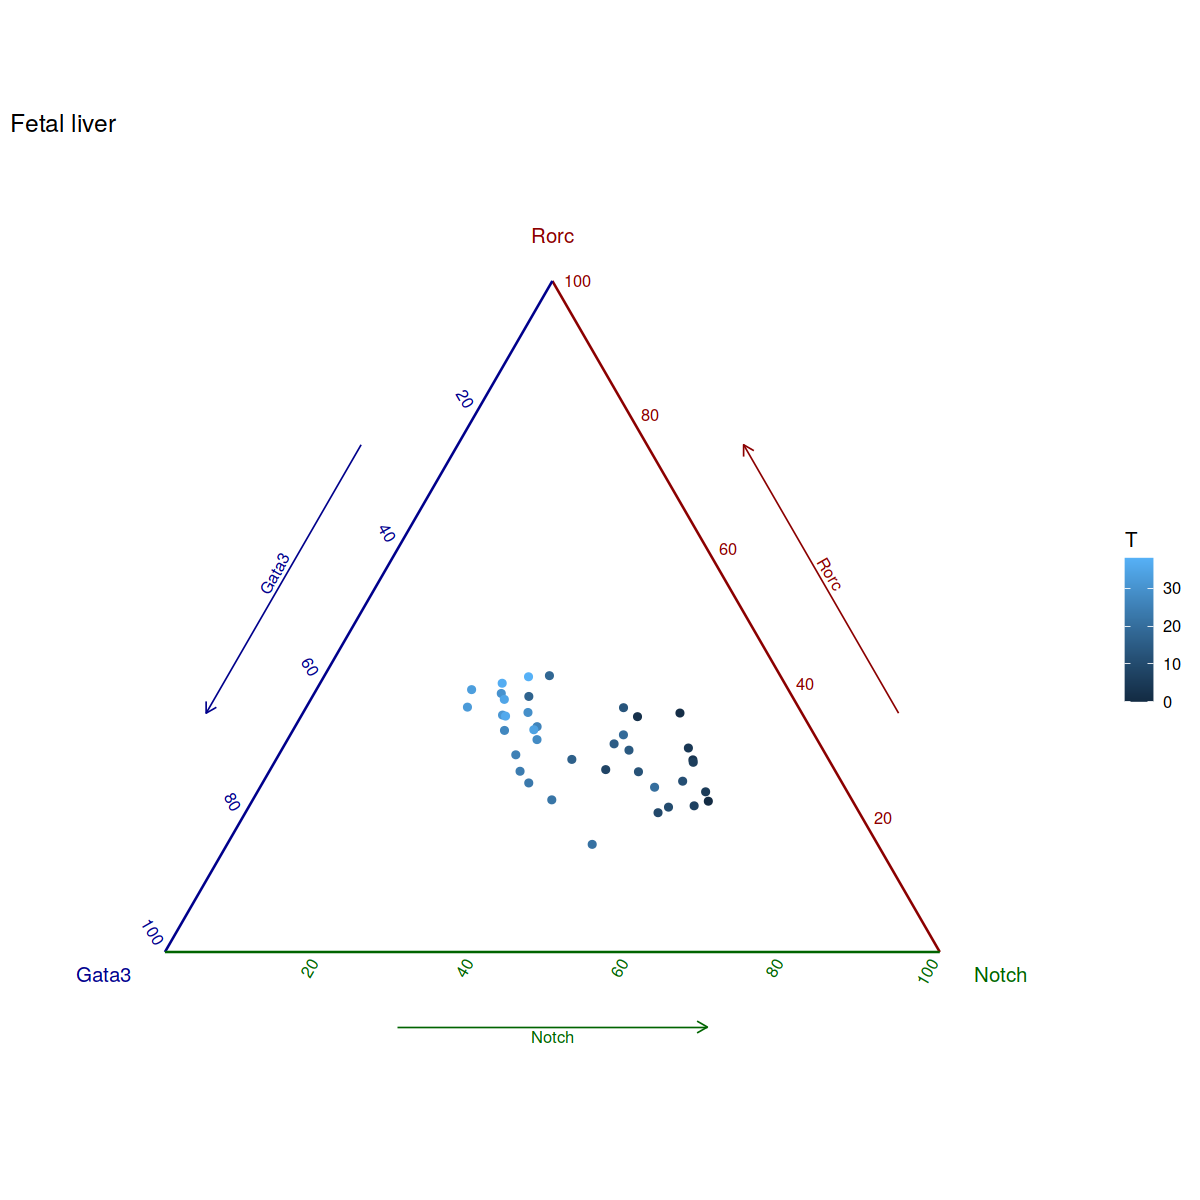

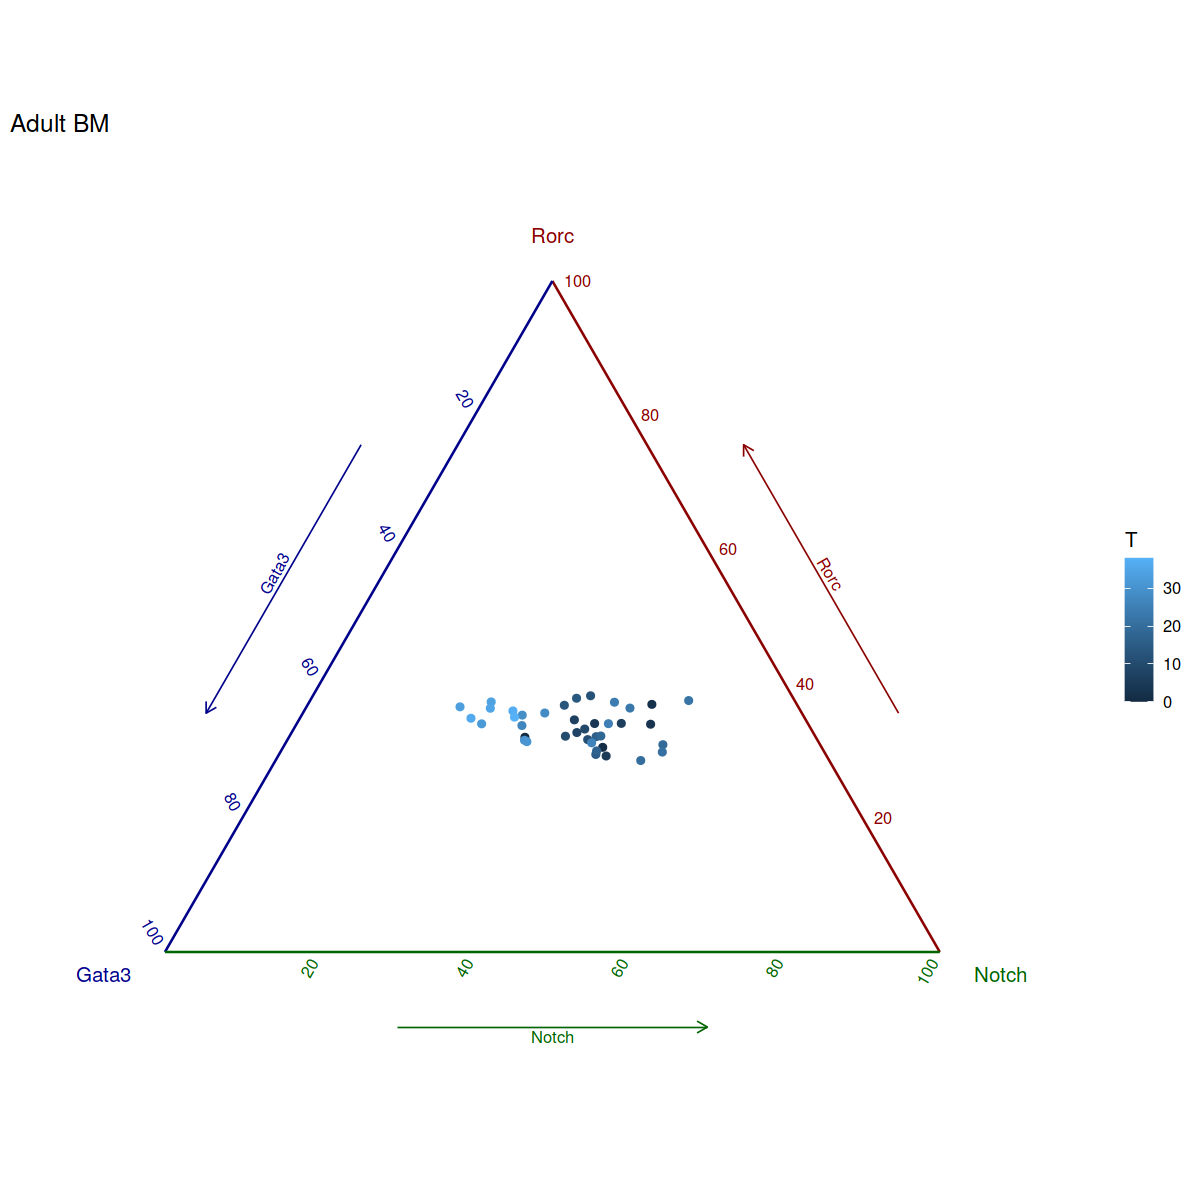

In [147]:
library(ggtern)
data<- as.data.frame(t(gsva.result.fl))
data$T =seq(0, nrow(data)-1)
set.seed(10)
o(10,10)
plot <- ggtern(data = data,
               aes(Gata3, Rorc, Notch))
plot + 
  geom_point(aes(colour=T)) + theme_rgbw() +
  scale_fill_gradient(low = "blue",high = "red")  +
  #guides(color = "none", fill = "none", alpha = "none")+
  labs(title = "Fetal liver")


library(ggtern)
data<- as.data.frame(t(gsva.result.abm))
data$T =seq(0, nrow(data)-1)
set.seed(10)
o(10,10)
plot <- ggtern(data = data,
               aes(Gata3, Rorc, Notch))
plot +  
  geom_point(aes(colour=T)) + theme_rgbw() +
  scale_fill_gradient(low = "blue",high = "red")  +
  #guides(color = "none", fill = "none", alpha = "none")+
  labs(title = "Adult BM")



In [185]:
o(7,3)
library(RColorBrewer)
breakList = seq(0, 0.2, by=0.01)
color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breakList))

pheatmap(aucell.result.fl, cluster_cols = F, color =color, breaks = breakList )
pheatmap(aucell.result.abm, cluster_cols = F,color =color, breaks = breakList)



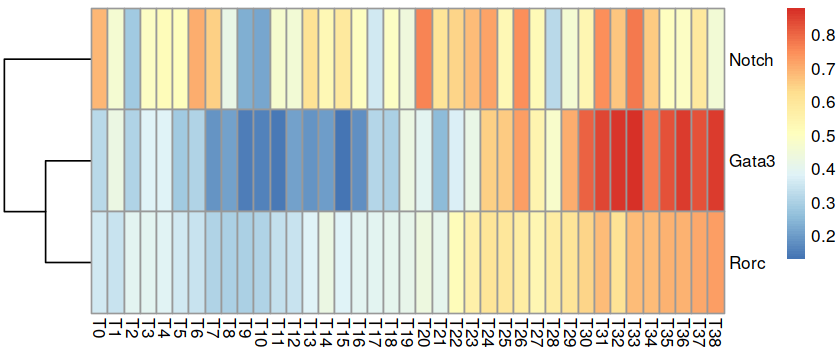

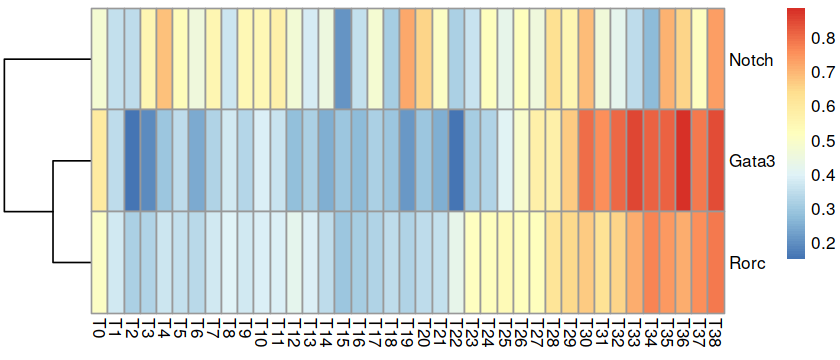

In [199]:
o(7,3)
pheatmap(gsva.result.fl, cluster_cols = F)
pheatmap(gsva.result.abm, cluster_cols = F)
